In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
pd.set_option('display.max_columns', None)
from rapidfuzz import process, fuzz
from sklearn.feature_selection import RFE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Metadata

#### Attribute Description
- carID - An attribute that contains an identifier for each car.
- Brand - The car’s main brand (e.g. Ford, Toyota).
- model - The car model.
- year - The year of Registration of the Car.
- mileage - The total reported distance travelled by the car (in miles).
- tax - The amount of road tax (in £) that, in 2020, was applicable to the car in question. 
- fuelType - Type of Fuel used by the car (Diesel, Petrol, Hybrid, Electric).
- mpg - Average Miles per Gallon.
- engineSize - Size of Engine in liters (Cubic Decimeters).
- paintQuality% - The mechanic’s assessment of the cars’ overall paint quality and hull integrity (filled by the mechanic during evaluation). 
- previousOwners - Number of previous registered owners of the vehicle.
- hasDamage - Boolean marker filled by the seller at the time of registration stating whether the car is damaged or not.
- price - The car’s price when purchased by Cars 4 You (in £).

# Reading the Data

In [2]:
df_train = pd.read_csv("../project_data/original_data/train.csv")
#df_test = pd.read_csv("../project_data/original_data/test.csv")

# 1. Geral Analysis

In [3]:
df_train.tail(20)

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
75953,71932,VW,golf sv,2020.0,21490,Semi-Auto,1177.0,Petrol,145.0,42.80000,1.5,36.0,4.0,0.0
75954,28693,Ford,Kuga,2017.0,16495,Manual,25352.0,Diesel,145.0,60.10000,2.0,51.0,4.0,0.0
75955,53707,Toyota,Yaris,2017.0,10498,Manual,9857.0,Petrol,30.0,55.00000,1.3,58.0,1.0,0.0
75956,5311,Audi,Q5,2019.0,37900,Semi-Auto,1027.0,Diesel,150.0,38.20000,2.0,31.0,2.0,0.0
75957,67969,VW,T-Roc,2019.0,32490,Automatic,9475.0,Petrol,145.0,32.50000,2.0,62.0,3.0,0.0
75958,64925,Opel,Corsa,2017.0,7299,Manual,41616.0,Petrol,20.0,61.40000,1.0,82.0,2.0,0.0
75959,62955,Opel,Corsa,2017.0,7325,Manual,36154.0,Petrol,150.0,55.40000,1.4,79.0,4.0,0.0
75960,59735,Opel,Grandland X,2018.0,16499,Automatic,13562.0,Petrol,145.0,54.30000,1.2,65.0,2.0,0.0
75961,769,Audi,A1,2016.0,10790,Manual,41914.0,Petrol,0.0,67.30000,1.0,39.0,4.0,0.0
75962,64820,Opel,Astra,2016.0,8990,Manual,9370.0,NaN,20.0,64.20000,1.0,43.0,4.0,0.0


#### First Insights
- The Data Set has 75973 rows and 14 columns.
- FuelType contains typos like "etrol", "iesel", "Petro" that should be corrected.
- Tax column contains missing (NaN) values.

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


#### Info() Obsevations
- All columns contain missing values except for carID and price.
- Year is stored as a float but should be an integer (int).
- Mileage is stored as a float but should be an integer (int).
- PreviousOwners is stored as a float but should be an integer (int).
- HasDamage is stored as a float but should be a boolean (bool).

In [5]:
df_train.describe()

,carID,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
count,75973.000000,74482.000000,75973.000000,74510.000000,68069.000000,68047.000000,74457.000000,74449.000000,74423.000000,74425.0
mean,37986.000000,2017.096611,16881.889553,23004.184088,120.329078,55.152666,1.660136,64.590667,1.994580,0.0
std,21931.660338,2.208704,9736.926322,22129.788366,65.521176,16.497837,0.573462,21.021065,1.472981,0.0
min,0.000000,1970.000000,450.000000,-58540.574478,-91.121630,-43.421768,-0.103493,1.638913,-2.345650,0.0
25%,18993.000000,2016.000000,10200.000000,7423.250000,125.000000,46.300000,1.200000,47.000000,1.000000,0.0
50%,37986.000000,2017.000000,14699.000000,17300.000000,145.000000,54.300000,1.600000,65.000000,2.000000,0.0
75%,56979.000000,2019.000000,20950.000000,32427.500000,145.000000,62.800000,2.000000,82.000000,3.000000,0.0
max,75972.000000,2024.121759,159999.000000,323000.000000,580.000000,470.800000,6.600000,125.594308,6.258371,0.0


#### describe() Observations
- Mileage has negative values (min is -58,540.57) which are impossible.
- Tax has negative values (min is -91.12) which are impossible.
- MPG has negative values (min is -43.42) which are invalid.
- EngineSize has negative values (min is -0.10) which are invalid.
- PaintQuality% has values above 100% and negatives which represent incorrect data.
- PreviousOwners has negative values (min is - i2.35) which are invalid.
- Year maximum is 2024.12 which is likely a typo or float conversion error.

# 2. Univariate Analysis

## 2.1. CarID

Checking Nans.

In [6]:
df_train['carID'].isna().sum()

np.int64(0)

Checking Nans.

Cheking duplicates IDs.

In [7]:
df_train['carID'].duplicated().sum()

np.int64(0)

In [8]:
df_train['carID'].nunique()

75973

#### CarID Observations
- No Nan values found for CarID.
- No CarID duplicates found.
- No issues for carID
- Seems a useless variable for predicting, but still will not be removed now

## 2.2. Brand & Model

### 2.2.1 Brand

Checking Nans.

In [9]:
df_train['Brand'].isna().sum()

np.int64(1521)

Checking Inconsistences.

In [10]:
df_train['Brand'].unique()

array(['VW', 'Toyota', 'Audi', 'Ford', 'BMW', 'Skoda', 'Opel', 'Mercedes',
       'FOR', 'mercedes', 'Hyundai', 'w', 'ord', 'MW', 'bmw', nan,
       'yundai', 'BM', 'Toyot', 'udi', 'Ope', 'AUDI', 'V', 'opel', 'pel',
       'For', 'pe', 'Mercede', 'audi', 'MERCEDES', 'OPEL', 'koda', 'FORD',
       'Hyunda', 'W', 'Aud', 'vw', 'hyundai', 'skoda', 'ford', 'TOYOTA',
       'ercedes', 'oyota', 'toyota', 'SKODA', 'Skod', 'HYUNDAI', 'kod',
       'v', 'for', 'SKOD', 'aud', 'KODA', 'PEL', 'yunda', 'or', 'UDI',
       'OYOTA', 'HYUNDA', 'mw', 'OPE', 'mercede', 'ERCEDES', 'ercede',
       'TOYOT', 'MERCEDE', 'ORD', 'ud', 'ope', 'AUD', 'hyunda', 'skod',
       'toyot'], dtype=object)

The 'Brand' column has many inconsistencies in uppercase/lowercase letters and spelling errors.

In [11]:
# Normalizing all strings to lowercase.
df_train['Brand'] = df_train['Brand'].str.lower()

In [12]:
# Cheking all the unique values of 'Brand'.
df_train['Brand'].unique()

array(['vw', 'toyota', 'audi', 'ford', 'bmw', 'skoda', 'opel', 'mercedes',
       'for', 'hyundai', 'w', 'ord', 'mw', nan, 'yundai', 'bm', 'toyot',
       'udi', 'ope', 'v', 'pel', 'pe', 'mercede', 'koda', 'hyunda', 'aud',
       'ercedes', 'oyota', 'skod', 'kod', 'yunda', 'or', 'ercede', 'ud'],
      dtype=object)

In [13]:
# Cheking all the unique values of 'Brand' sorted alphabetically.
sorted(df_train['Brand'].dropna().unique())

['aud',
 'audi',
 'bm',
 'bmw',
 'ercede',
 'ercedes',
 'for',
 'ford',
 'hyunda',
 'hyundai',
 'kod',
 'koda',
 'mercede',
 'mercedes',
 'mw',
 'ope',
 'opel',
 'or',
 'ord',
 'oyota',
 'pe',
 'pel',
 'skod',
 'skoda',
 'toyot',
 'toyota',
 'ud',
 'udi',
 'v',
 'vw',
 'w',
 'yunda',
 'yundai']

### 2.2.2. Model

Cheking Nans.

In [14]:
df_train['model'].isna().sum()

np.int64(1517)

Checking Inconsistences.

In [15]:
# Checking the unique values of the 'model column.
df_train['model'].dropna().unique()

array([' Golf', ' Yaris', ' Q2', ' FIESTA', ' 2 Series', '3 Series',
       ' A3', ' Octavia', ' Passat', ' Focus', ' Insignia', ' A Clas',
       ' Q3', ' Fabia', ' A Class', ' Ka+', ' 3 Series', ' GLC Class',
       ' I30', ' C Class', ' Polo', ' E Class', ' C Clas', ' Q5', ' Up',
       ' Fiesta', ' C-HR', ' Mokka X', ' Corsa', ' Astra', ' TT',
       ' 5 Series', ' Aygo', ' 4 Series', ' SLK', ' Viva', ' T-Roc',
       'Focus', ' EcoSport', ' Tucson', ' EcoSpor', ' X-CLASS',
       ' CL Class', ' IX20', ' i20', ' Rapid', ' a1', ' Auris', ' sharan',
       ' I20', ' Adam', ' X3', ' A8', ' GLS Class', ' B-MAX', ' A4',
       ' Kona', ' I10', ' A1', ' Mokka', ' fiesta', ' S-MAX', ' X2',
       ' Crossland X', ' Tiguan', ' A5', ' GLE Class', ' C CLASS',
       ' mokka x', ' Zafira', ' Ioniq', ' A6', ' Mondeo', ' Yeti Outdoor',
       ' X1', 'POLO', ' INSIGNIA', ' Scala', ' S Class', ' 1 Series',
       ' Kamiq', ' Kuga', ' Tourneo Connect', ' Q7', ' GLA Class',
       ' Arteon', ' polo'

Several typing errors are identified, such as missing letters and extra spaces at the beginning of strings.

In [16]:
# Checking the unique values of the 'model' column in alphabetical order.
sorted(df_train['model'].dropna().unique())[:20]

[' 1 SERIE',
 ' 1 SERIES',
 ' 1 Serie',
 ' 1 Series',
 ' 1 serie',
 ' 1 series',
 ' 2 SERIES',
 ' 2 Serie',
 ' 2 Series',
 ' 2 serie',
 ' 2 series',
 ' 3 SERIES',
 ' 3 Serie',
 ' 3 Series',
 ' 3 serie',
 ' 3 series',
 ' 4 SERIES',
 ' 4 Serie',
 ' 4 Series',
 ' 4 serie']

Since some values are written in lowercase and others in uppercase for the same car model, we will convert everything to lowercase to simplify the analysis.

In [17]:
df_train['model'] = df_train['model'].str.lower().str.replace('-', ' ')

Building a function 'remove_leading_spaces' to remove initial empty spaces.

In [18]:
# Function to remove leading space if it exists.
def remove_leading_space(s):
    if isinstance(s, str) and s.startswith(' '):
        return s[1:]  # remove the first character.
    return s

# Apply the function to the 'model' column.
df_train['model'] = df_train['model'].apply(remove_leading_space)

In [19]:
# Show the ordered unique values of model column after removing leading spaces.
sorted(df_train['model'].dropna().unique())

['1 serie',
 '1 series',
 '2 serie',
 '2 series',
 '200',
 '220',
 '230',
 '3 serie',
 '3 series',
 '4 serie',
 '4 series',
 '5 serie',
 '5 series',
 '6 serie',
 '6 series',
 '7 serie',
 '7 series',
 '8 serie',
 '8 series',
 'a',
 'a clas',
 'a class',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a7',
 'a8',
 'accent',
 'ada',
 'adam',
 'agila',
 'amaro',
 'amarok',
 'ampera',
 'antara',
 'arteo',
 'arteon',
 'astr',
 'astra',
 'auri',
 'auris',
 'avensis',
 'ayg',
 'aygo',
 'b clas',
 'b class',
 'b ma',
 'b max',
 'beetl',
 'beetle',
 'c clas',
 'c class',
 'c h',
 'c hr',
 'c ma',
 'c max',
 'caddy',
 'caddy life',
 'caddy maxi',
 'caddy maxi lif',
 'caddy maxi life',
 'california',
 'camry',
 'caravell',
 'caravelle',
 'cascada',
 'cc',
 'citig',
 'citigo',
 'cl clas',
 'cl class',
 'cla class',
 'clc class',
 'clk',
 'cls clas',
 'cls class',
 'combo lif',
 'combo life',
 'coroll',
 'corolla',
 'cors',
 'corsa',
 'crossland ',
 'crossland x',
 'e clas',
 'e class',
 'ecospor',
 'ec

### 2.2.3. Spelling Correction and Data Standardization - Fuzzy Matching

To ensure the quality and consistency of the brand and model columns, we standardized the data using a two-step approach:
- **Data Validation Source (Web Scraping):** We scraped the Autotrader website to compile an exhaustive catalogue of all valid car brand, models and brand-model pairs. (Web scraping code is located in the WebScraping_AutoTrader.ipynb notebook)
- **Fuzzy Matching & Mapping:** We applied fuzzy matching techniques to compare our train.csv dataset against the validated Autotrader list. This allowed us to automatically map and correct misspelled or inconsistent entries in our dataset to their official, correct names, ensuring data integrity for modeling.

Import of catalogue

In [20]:
catalog = pd.read_csv('../project_data/make_model_catalog.csv')

In [21]:
catalog.head(5)

,make,model
0,AC,Cobra
1,AC,Dax Cobra
2,AK,Cobra
3,Abarth,124 Spider
4,Abarth,500


clean the make (brand) and model columns to match what we did in the train dataset

In [22]:
catalog['make'] = catalog['make'].str.lower().str.strip()
catalog['model'] = catalog['model'].str.lower().str.replace('-', ' ')
catalog['model'] = catalog['model'].apply(remove_leading_space)

In [23]:
cat = catalog.copy()
df = df_train.copy()

#### Match and map of car brand

In [24]:
def rf_top1(query, choices, scorer=fuzz.ratio):
    match = process.extractOne(query, choices, scorer=scorer)
    if match is None:
        return np.nan, 0.0
    return match[0], match[1]

In [25]:
df.columns

Index(['carID', 'Brand', 'model', 'year', 'price', 'transmission', 'mileage',
       'fuelType', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'hasDamage'],
      dtype='object')

In [26]:
makes_norm = cat["make"].unique().tolist()
brand_uniques = df["Brand"].unique().tolist()

In [27]:
brand_map = {}
for br in brand_uniques:
    best, sc = rf_top1(br, makes_norm, scorer=fuzz.ratio)  # ou fuzz.WRatio se houver muito ruído
    brand_map[br] = {'match':best, 'score': sc}

In [28]:
brand_map

{'vw': {'match': 'vw', 'score': 100.0},
 'toyota': {'match': 'toyota', 'score': 100.0},
 'audi': {'match': 'audi', 'score': 100.0},
 'ford': {'match': 'ford', 'score': 100.0},
 'bmw': {'match': 'bmw', 'score': 100.0},
 'skoda': {'match': 'skoda', 'score': 100.0},
 'opel': {'match': 'opel', 'score': 100.0},
 'mercedes': {'match': 'mercedes', 'score': 100.0},
 'for': {'match': 'ford', 'score': 85.71428571428572},
 'hyundai': {'match': 'hyundai', 'score': 100.0},
 'w': {'match': 'vw', 'score': 66.66666666666667},
 'ord': {'match': 'ford', 'score': 85.71428571428572},
 'mw': {'match': 'bmw', 'score': 80.0},
 nan: {'match': nan, 'score': 0.0},
 'yundai': {'match': 'hyundai', 'score': 92.3076923076923},
 'bm': {'match': 'bmw', 'score': 80.0},
 'toyot': {'match': 'toyota', 'score': 90.9090909090909},
 'udi': {'match': 'audi', 'score': 85.71428571428572},
 'ope': {'match': 'opel', 'score': 85.71428571428572},
 'v': {'match': 'vw', 'score': 66.66666666666667},
 'pel': {'match': 'opel', 'score':

In [29]:
THRESH_BRAND = 75
filtered_map = {
    key: nested_dict['match']
    for key, nested_dict in brand_map.items()
    if nested_dict['score'] >= THRESH_BRAND
}
filtered_map['v'] = 'vw'

In [30]:
df["brand_clean"] = df['Brand'].map(filtered_map)
df

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,brand_clean
0,69512,vw,golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0,vw
1,53000,toyota,yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0,toyota
2,6366,audi,q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0,audi
3,29021,ford,fiesta,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0,ford
4,10062,bmw,2 series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0,bmw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75968,37194,mercedes,c class,2015.0,13498,Manual,14480.0,etrol,125.0,53.300000,2.0,78.0,0.000000,0.0,mercedes
75969,6265,audi,q3,2013.0,12495,Semi-Auto,52134.0,Diesel,200.0,47.900000,2.0,38.0,2.000000,0.0,audi
75970,54886,toyota,aygo,2017.0,8399,Automatic,11304.0,Petrol,145.0,67.000000,1.0,57.0,3.000000,0.0,toyota
75971,860,audi,q3,2015.0,12990,Manual,69072.0,iesel,125.0,60.100000,2.0,74.0,2.000000,0.0,audi


#### Match and map car model within his brand

In [31]:
# index de modelos por make normalizada
models_by_make = {
    mk: (
        sorted(g["model"].unique().tolist())    )
    for mk, g in cat.groupby("make")
}

mod_by_fil_make = [
    sorted(g["model"].unique().tolist())
    for mk, g in cat.groupby("make")
    if mk in list(set(filtered_map.values()))
]
mod_by_fil_make = [item for sublist in mod_by_fil_make for item in sublist]

In [32]:
def match_model_in_make(model, brand_clean, brand):
    if pd.isna(brand):
        all_models = mod_by_fil_make
        best, sc = rf_top1(model, all_models, scorer=fuzz.ratio)
        if sc >= THRESH_MODEL_NO_BRAND:
            return best, sc
        else:
            return np.nan, 0.0
    if pd.isna(brand_clean):
        return np.nan, 0.0
    else:
        models_make = models_by_make[brand_clean]
        best, sc = rf_top1(model, models_make, scorer=fuzz.ratio) 
        if sc > THRESH_MODEL:
            return best, sc
        else:
            return np.nan, 0.0

THRESH_MODEL = 70.0
THRESH_MODEL_NO_BRAND = 80
tmp = df.apply(lambda r: match_model_in_make(r["model"], r["brand_clean"], r["Brand"]), axis=1)

In [33]:
df["model_clean_tmp"] = [t[0] for t in tmp]
df["model_score_inmake"] = [t[1] for t in tmp]

#### Match and map pairs brand-model when brand alone was not sufficient

In [34]:
pairs_df = cat[["make","model"]].copy()
def fallback_pair(row):
    if not pd.isna(row["brand_clean"]) or pd.isna(row["Brand"]) or pd.isna(row["model"]):
        return np.nan, np.nan, 0.0
    mk_cands = [m for (m,_,_) in process.extract(row["Brand"], makes_norm, scorer=fuzz.ratio, limit=5)]
    if not mk_cands:
        return np.nan, np.nan, 0.0
    sub = pairs_df[pairs_df["make"].isin(mk_cands)].copy()
    q = (row["Brand"] + " " + row["model"])
    choices = (sub["make"] + " " + sub["model"]).tolist()
    best_pair, score = rf_top1(q, choices, scorer=fuzz.ratio)
    hit = sub.loc[(sub["make"] + " " + sub["model"])==best_pair].iloc[0]
    return hit['make'], hit['model'], score

fb = df.apply(fallback_pair, axis=1, result_type="expand")

df["pair_make"], df["pair_model"], df["pair_score"] = fb[0], fb[1], fb[2]

In [35]:
df.loc[(df['pair_score'] > 0) & (df['pair_score'] < 70)]

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,brand_clean,model_clean_tmp,model_score_inmake,pair_make,pair_model,pair_score
54276,67383,w,u,2012.0,5499,Manual,54196.0,Petrol,20.0,60.1,1.0,63.0,2.0,0.0,NaN,NaN,0.0,vw,up!,66.666667


In [36]:
THRESH_PAIR = 65

In [37]:
def pick_brand(row):
    if pd.isna(row["brand_clean"]):
        if row["pair_score"] >= THRESH_PAIR:
            return row["pair_make"]
        else:
            return np.nan
    else:
        return row["brand_clean"]

def pick_model(row):
    if pd.isna(row["model_clean_tmp"]):
        if row["pair_score"] >= THRESH_PAIR:
            return row["pair_model"]
        else:
            return np.nan
    else:
        return row["model_clean_tmp"]

df["brand_final"] = df.apply(pick_brand, axis=1)
df["model_final"] = df.apply(pick_model, axis=1)

### 2.2.4. Brand mapping by model

Since we can map a brand to a specific model we used this to input some of the nan values in the brand variable

In [38]:
MIN_SUPPORT = 2          

gb = df.groupby("model_final")
n_brands_by_model = gb["brand_final"].nunique()

count_by_pair = df.groupby(["model_final","brand_final"]).size().sort_values(ascending=False)

non_ambiguous_models = n_brands_by_model[n_brands_by_model == 1].index

In [39]:
top_brand_per_model = (
    count_by_pair.reset_index().rename(columns={0:"n"})
    .loc[lambda d: d["model_final"].isin(non_ambiguous_models)]
)

In [40]:
top_brand_per_model = top_brand_per_model.loc[top_brand_per_model['n'] >= MIN_SUPPORT]
model2brand_key = dict(zip(top_brand_per_model["model_final"], top_brand_per_model["brand_final"]))

In [41]:
df.loc[df['Brand'].isna(), "brand_final"] = df.loc[df['Brand'].isna(), "model_final"].map(model2brand_key)

In [42]:
df

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,brand_clean,model_clean_tmp,model_score_inmake,pair_make,pair_model,pair_score,brand_final,model_final
0,69512,vw,golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0,vw,golf,100.0,NaN,NaN,0.0,vw,golf
1,53000,toyota,yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0,toyota,yaris,100.0,NaN,NaN,0.0,toyota,yaris
2,6366,audi,q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0,audi,q2,100.0,NaN,NaN,0.0,audi,q2
3,29021,ford,fiesta,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0,ford,fiesta,100.0,NaN,NaN,0.0,ford,fiesta
4,10062,bmw,2 series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0,bmw,2 series,100.0,NaN,NaN,0.0,bmw,2 series
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75968,37194,mercedes,c class,2015.0,13498,Manual,14480.0,etrol,125.0,53.300000,2.0,78.0,0.000000,0.0,mercedes,c class,100.0,NaN,NaN,0.0,mercedes,c class
75969,6265,audi,q3,2013.0,12495,Semi-Auto,52134.0,Diesel,200.0,47.900000,2.0,38.0,2.000000,0.0,audi,q3,100.0,NaN,NaN,0.0,audi,q3
75970,54886,toyota,aygo,2017.0,8399,Automatic,11304.0,Petrol,145.0,67.000000,1.0,57.0,3.000000,0.0,toyota,aygo,100.0,NaN,NaN,0.0,toyota,aygo
75971,860,audi,q3,2015.0,12990,Manual,69072.0,iesel,125.0,60.100000,2.0,74.0,2.000000,0.0,audi,q3,100.0,NaN,NaN,0.0,audi,q3


In [43]:
df_train = df[['carID', 'brand_final', 'model_final', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg', 'engineSize','paintQuality%', 'previousOwners','hasDamage']].rename(columns={'brand_final':'brand', 'model_final':'model'}).copy()
df_train

,carID,brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,vw,golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,toyota,yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,audi,q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,ford,fiesta,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,bmw,2 series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75968,37194,mercedes,c class,2015.0,13498,Manual,14480.0,etrol,125.0,53.300000,2.0,78.0,0.000000,0.0
75969,6265,audi,q3,2013.0,12495,Semi-Auto,52134.0,Diesel,200.0,47.900000,2.0,38.0,2.000000,0.0
75970,54886,toyota,aygo,2017.0,8399,Automatic,11304.0,Petrol,145.0,67.000000,1.0,57.0,3.000000,0.0
75971,860,audi,q3,2015.0,12990,Manual,69072.0,iesel,125.0,60.100000,2.0,74.0,2.000000,0.0


Visualizing brand on a Countplot

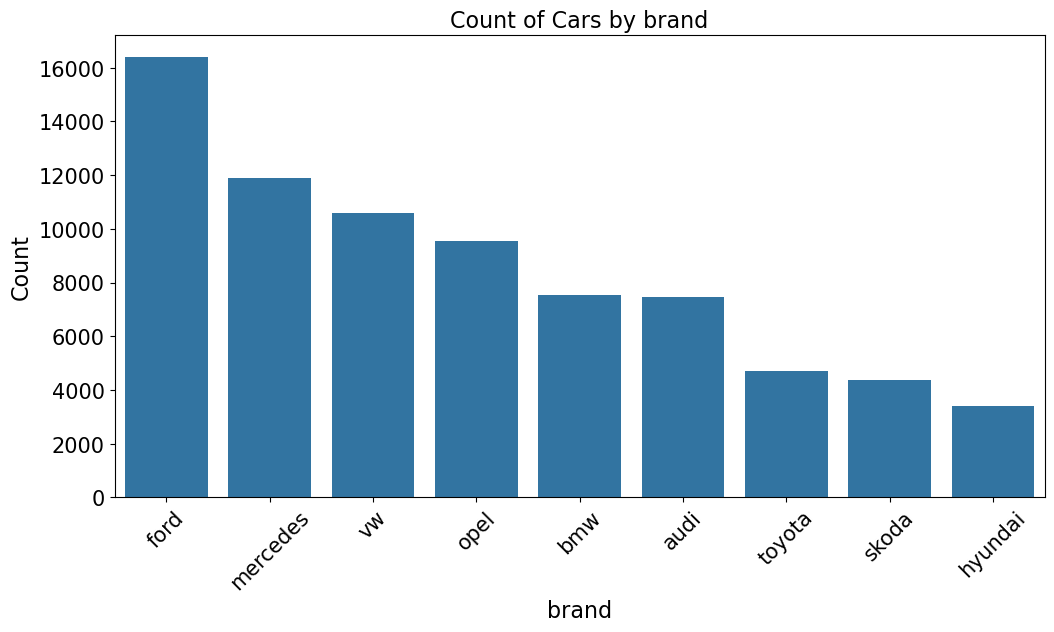

In [44]:
plt.figure(figsize=(12,6))
sns.countplot(data=df_train, x='brand', order=df_train['brand'].value_counts().index)

plt.xticks(rotation=45, fontsize=15) 
plt.yticks(fontsize=15)               
plt.title('Count of Cars by brand', fontsize=16) 
plt.xlabel('brand', fontsize=16)     
plt.ylabel('Count', fontsize=16)     
plt.show()

#### Brand Observations
- Data cleaning: inconsistencies in uppercase/lowercase and spelling errors corrected.
- Most frequent brands: Ford is the most common, followed by Mercedes and VW.

In [45]:
# Checking the number of NaN values in the 'model' column after applying the replacements.
df_train['model'].isna().sum()

np.int64(1721)

Visualizing model on a Countplot

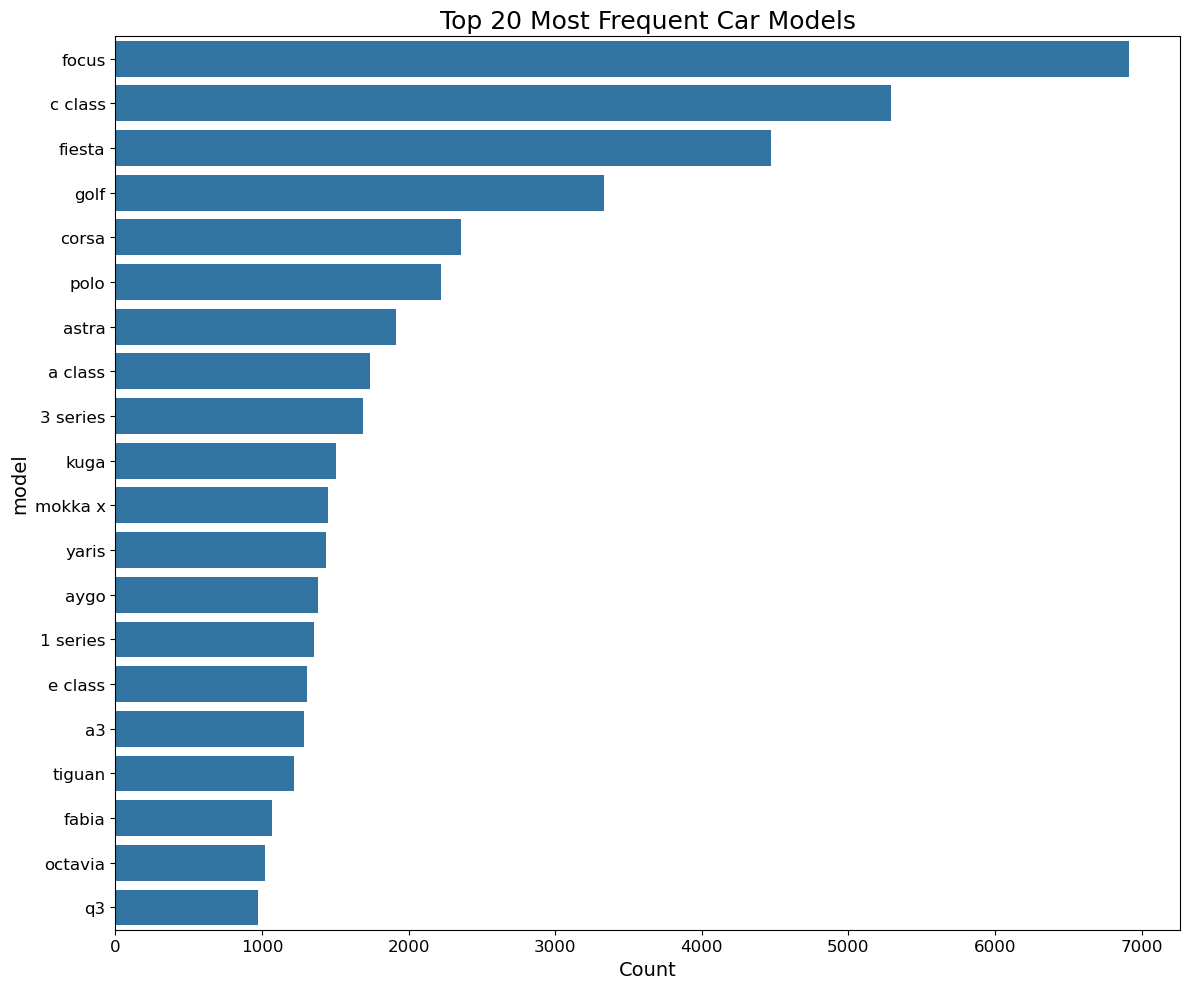

In [46]:
# Select the top 20 most frequent car models.
top_models = df_train['model'].value_counts().nlargest(20).index

plt.figure(figsize=(12, 10))

sns.countplot(
    y='model',
    data=df_train,
    order=top_models,
)

plt.title('Top 20 Most Frequent Car Models', fontsize=18)
plt.xlabel('Count', fontsize=14)
plt.ylabel('model', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

#### Model Observations
- Typing issues fixed: each value was evaluated and corrected with fuzzy matching, including removal of extra whitespace.
- Most frequent models: visually, Focus is the most common, followed by C-Class and Fiesta.

#### Model + Brand
 
 - At first glance we will have 2 options: either build a model that takes into consideration combinations of brand+model or just takes into consideration the brand.
 - If we choose the 1st one we will have to worry about the "trap" of having to many variables (curse of dimensionality)

## 2.3. Year

Cheking Nans.

In [47]:
df_train['year'].isna().sum()

np.int64(1491)

Checking Inconsistences.

In [48]:
df_train['year'].unique()

array([2016.        , 2019.        , 2018.        , 2014.        ,
       2017.        , 2020.        , 2013.        ,           nan,
       2015.        , 2023.36707842, 2011.        , 2012.        ,
       2023.1169636 , 2003.        , 2009.        , 2007.        ,
       2005.        , 2011.11118842, 2011.21085349, 2023.97731126,
       2004.        , 2010.        , 2010.56500919, 2008.        ,
       2024.12175905, 2006.        , 2023.60527574, 2023.38982198,
       2010.67696784, 2001.        , 2000.        , 2023.26798867,
       2010.26863473, 2010.37154646, 2002.        , 2022.69668507,
       2009.81675711, 2010.7464032 , 2012.69574039, 1996.        ,
       1998.        , 2022.87800554, 1970.        , 1999.        ,
       1997.        ])

These decimal places doesn´t make sense. We decided to round them to the nearest whole number.

In [49]:
df_train['year'] = df_train['year'].apply(lambda x: int(round(x)) if pd.notnull(x) else np.nan)

In [50]:
df_train['year'].unique()

array([2016., 2019., 2018., 2014., 2017., 2020., 2013.,   nan, 2015.,
       2023., 2011., 2012., 2003., 2009., 2007., 2005., 2024., 2004.,
       2010., 2008., 2006., 2001., 2000., 2002., 1996., 1998., 1970.,
       1999., 1997.])

Now we can convert the dtype float to int.

In [51]:
df_train['year'] = df_train['year'].astype('Int64')

In [52]:
df_train['year'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 75973 entries, 0 to 75972
Series name: year
Non-Null Count  Dtype
--------------  -----
74482 non-null  Int64
dtypes: Int64(1)
memory usage: 667.9 KB


Since the database is from 2020 the year should not be higher than 2020, so we map these values to NaN

In [53]:
df_train.loc[df_train['year'] > 2020, 'year'] = np.nan

Visualizing year on a histogram and boxplot.

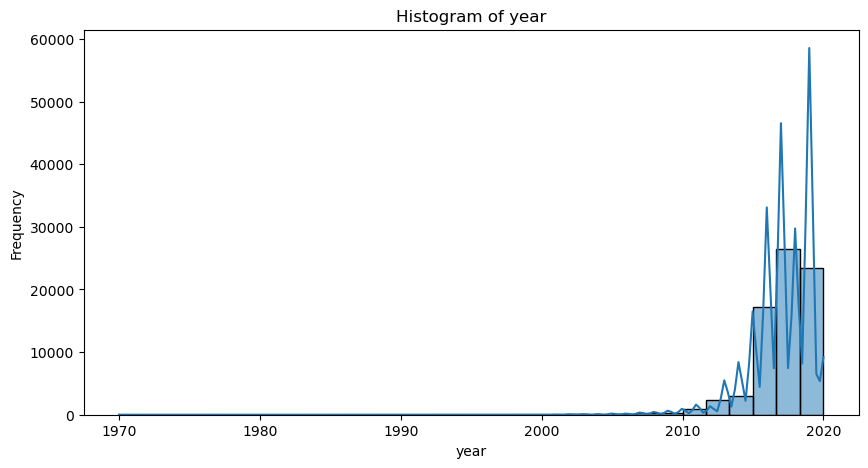

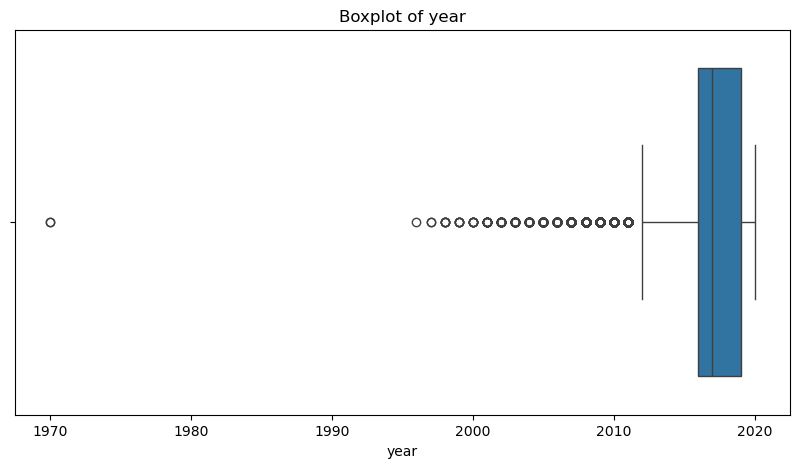

In [54]:
# Histogram.
plt.figure(figsize=(10,5))
sns.histplot(df_train['year'].dropna().astype(int), bins=30, kde=True) 
plt.title('Histogram of year')
plt.xlabel('year')
plt.ylabel('Frequency')
plt.show()

# Boxplot.
plt.figure(figsize=(10,5))
sns.boxplot(x=df_train['year'].dropna().astype(int))
plt.title('Boxplot of year')
plt.xlabel('year')
plt.show()

**Outliers**: 
- Cars between 1970 and 2010 can be considered outliers (looking at the boxplot).
- Feature engineering instead of deletion: we will later convert year to car_age. Age is the business-meaningful quantity and often has a more linear relation with price than raw year.

#### Year Observations
- Initial NaNs: 1,491.
- Years with decimals were rounded to the nearest integer.
- dtype converted to int.
- Data is mostly recent (2010–2020).

## 2.4. Mileage

Cheking Nan Values.

In [55]:
df_train['mileage'].isna().sum()

np.int64(1463)

Checking inconsistencies.

In [56]:
df_train['mileage'].head(15)

0      28421.000000
1       4589.000000
2       3624.000000
3       9102.000000
4       1000.000000
5     101153.348285
6      21396.000000
7     116750.000000
8      30339.000000
9      10700.000000
10     21123.000000
11      1000.000000
12     26360.000000
13     14378.000000
14      9500.000000
Name: mileage, dtype: float64

It doesn’t make sense to have so many decimal places when we’re talking about a vehicle’s mileage. The most appropriate approach is to convert these numbers to the nearest integers by changing the dtype to int64.

In [57]:
# Convert mileage to nearest integer.
df_train = df_train.copy()
df_train['mileage'] = df_train['mileage'].round()

In [58]:
# And change dtype to int64.
df_train['mileage'] = df_train['mileage'].astype('Int64')

In [59]:
df_train['mileage'].head(15)

0      28421
1       4589
2       3624
3       9102
4       1000
5     101153
6      21396
7     116750
8      30339
9      10700
10     21123
11      1000
12     26360
13     14378
14      9500
Name: mileage, dtype: Int64

From the describe() output in Chapter 1, we can see that the mileage contains some negative values. Let's analyze them.

In [60]:
df_train[df_train['mileage'] < 0]

,carID,brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
268,70615,vw,tiguan,2020,25000,Manual,-48191,Petrol,145.0,38.2,1.5,89.0,3.0,0.0
284,43529,mercedes,c class,2019,25780,Semi-Auto,-50755,Diesel,NaN,NaN,2.0,72.0,3.0,0.0
325,71090,vw,golf,2018,14995,Manual,-48191,Diesel,150.0,57.7,1.6,83.0,2.0,0.0
843,7845,bmw,3 series,2019,23498,Semi-Auto,-58541,Diesel,145.0,54.3,2.0,38.0,NaN,0.0
853,24999,ford,fiesta,2017,8895,Manual,-42650,Petrol,125.0,54.3,1.2,45.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74961,56373,opel,NaN,2018,8514,Manual,-42708,Petrol,150.0,55.4,1.4,49.0,1.0,NaN
75015,45765,mercedes,gle class,2020,54995,Automatic,-50755,Diesel,150.0,32.8,3.0,69.0,4.0,0.0
75423,38413,mercedes,slk,2015,17900,Automati,-50755,Diesel,150.0,56.5,2.1,40.0,3.0,0.0
75859,55820,toyota,aygo,2019,8491,Manual,-39766,Petrol,145.0,56.5,1.0,56.0,0.0,0.0


We have 361 negative mileage values. Although the absolute values seem plausible, since we cannot confirm their correctness, it's safer to mark them as missing (NaN).

In [61]:
# Replacing the negative mileage values with NaNs.
df_train.loc[df_train['mileage'] < 0, 'mileage'] = np.nan 

In [62]:
# Checking final number of Nan values in mileage column.
df_train['mileage'].isna().sum()

np.int64(1832)

Visualizing the variable mileage on a histogram and boxplot.

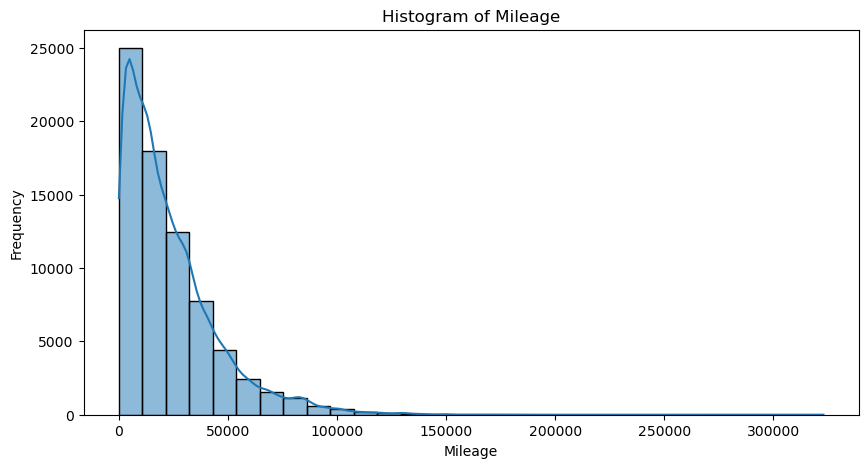

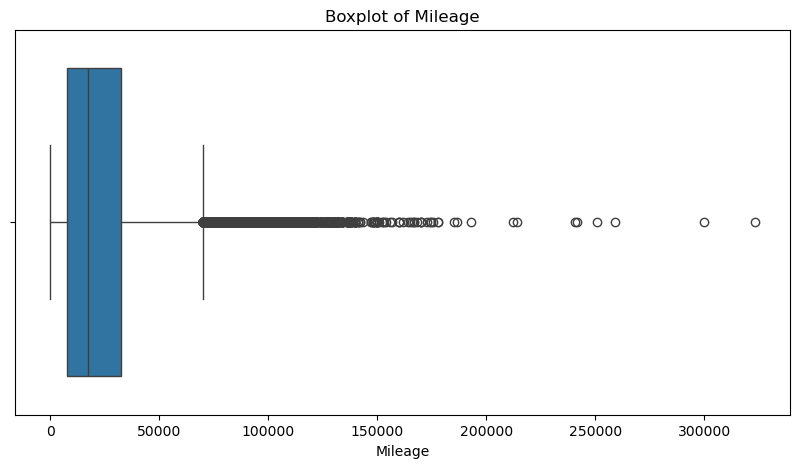

In [63]:
# Histogram
plt.figure(figsize=(10,5))
sns.histplot(df_train['mileage'].dropna().astype(int), bins=30, kde=True) 
plt.title('Histogram of Mileage')
plt.xlabel('Mileage')
plt.ylabel('Frequency')
plt.show()

# Boxplot
plt.figure(figsize=(10,5))
sns.boxplot(x=df_train['mileage'].dropna().astype(int))
plt.title('Boxplot of Mileage')
plt.xlabel('Mileage')
plt.show()

**Outliers:** 
- The distribution of this variable is highly right skewed with some extreme outliers which give disproportionate leverage to a few samples, hurting linear models and making scaling unstable. 
- The plan is to apply log1p. 
- log1p compresses the long right tail, stabilizes variance, and often linearizes multiplicative

#### Mileage Observations
- Initial NaNs: 1463.
- Floats rounded to integers; dtype converted to int.
- 361 negative mileage values detected - replaced with NaN.
- Final NaNs: 1862.
- Most cars have low mileage
- Very few cars exceed 50,000 miles.
- Outliers appear around ~75,000 miles.

## 2.5. Tax 

Cheking Nan Values.

In [64]:
df_train['tax'].isna().sum()

np.int64(7904)

Cheking Inconsistencies.

In [65]:
df_train['tax'].unique()

array([         nan, 145.        ,  30.        ,  20.        ,
       150.        , 160.        , -56.19320154,   0.        ,
       125.        , 200.        , 250.        , 135.        ,
       300.        , 205.        , 260.        , 326.02823317,
       325.        , -45.78061049, 265.        , 305.        ,
       303.14889146, 235.        , 299.47350391, 240.        ,
       165.        , 140.        , 540.        , 155.        ,
       220.        , 120.        , 330.        , 290.48678508,
       -20.24107949, -18.33074314, 327.91577835, 270.        ,
       115.        , 185.        , 316.48718937, 570.        ,
       -49.15354066, 316.29630636, -60.6840948 , 555.        ,
       277.38425448, -91.12163048,  10.        , 315.        ,
       190.        , -31.91494466, 230.        , -43.24208237,
       294.84340933, 195.        , 580.        , 290.        ,
       130.        , 565.        , 210.        , 280.        ,
       255.        , 520.        , 295.        , 245.  

We check for negative values in the 'tax' column, which are clearly errors.

In [66]:
(df_train['tax'] < 0).sum()

np.int64(378)

There are 369 negative values in the tax column. We cannot confirm whether their absolute values are correct, we will replace them with NaN.

In [67]:
# Replace negative tax values with NaN.
df_train.loc[df_train['tax'] < 0, 'tax'] = np.nan

In [68]:
# Final Number of Nan Values.
df_train['tax'].isna().sum()

np.int64(8282)

In [69]:
# ~11% of the variable is nan
(df_train['tax'].isna().sum() / len(df_train))* 100

np.float64(10.90124123043713)

Visualizing the variable tax on a histogram and boxplot.

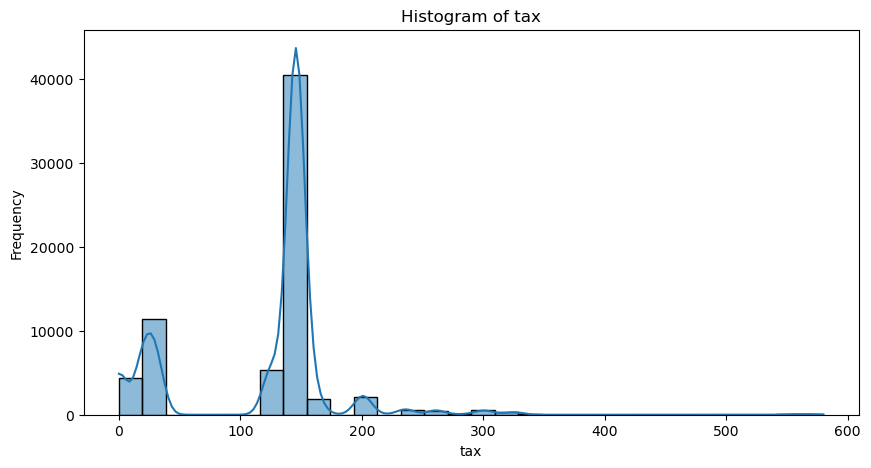

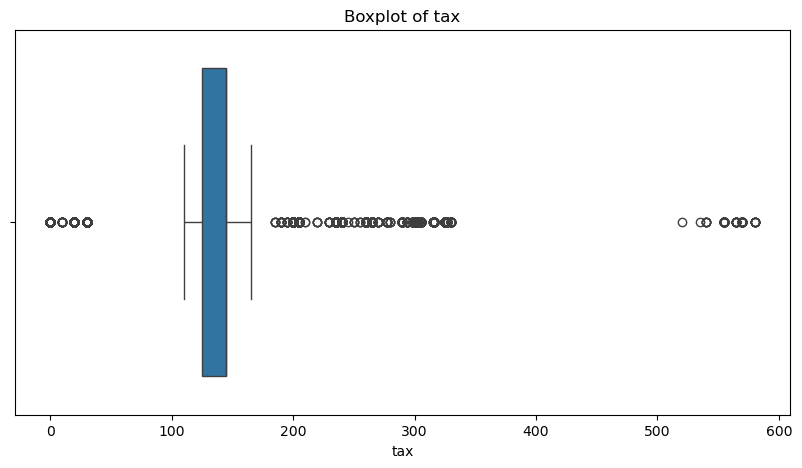

In [70]:
# Histogram.
plt.figure(figsize=(10,5))
sns.histplot(df_train['tax'].dropna().astype(int), bins=30, kde=True) 
plt.title('Histogram of tax')
plt.xlabel('tax')
plt.ylabel('Frequency')
plt.show()

# Boxplot.
plt.figure(figsize=(10,5))
sns.boxplot(x=df_train['tax'].dropna().astype(int))
plt.title('Boxplot of tax')
plt.xlabel('tax')
plt.show()

**Outliers:** 
- The distribution of this variable have some extreme outliers which give disproportionate leverage to a few samples and hurt linear models.
- This Variable is not right skewed enough to aplly log1p.
- We used capping to limit the extreme values to a defined percentile (We cap the outliers at the 1st and 99th percentile).

#### Tax Observations

- Initially 7904 NaNs; after cleaning, 8282 NaNs.
- Float values converted to int.
- Negative values replaced with NaN.
- Many high outliers, probably related with premium cars.

## 2.6. FuelType

Ckecking Nan values.

In [71]:
# Sum of all Nan values in fuelType variable.
df_train['fuelType'].isna().sum()

np.int64(1511)

Cheking Inconsistencies.

In [72]:
# Get unique values from the 'fuelType' column.
df_train['fuelType'].unique()

array(['Petrol', 'Diesel', 'etrol', 'Hybrid', 'diesel', 'iesel', nan,
       'petrol', 'PETROL', 'Diese', 'Petro', 'DIESEL', 'petro', 'HYBRID',
       'ybri', 'Other', 'DIESE', 'Hybri', 'ETROL', 'ybrid', 'PETRO',
       'hybrid', 'IESEL', 'Electric', 'ther', 'iese', 'etro', 'ETRO',
       'diese', 'Othe', 'YBRID', 'HYBRI', 'OTHER', 'other', 'IESE'],
      dtype=object)

In [73]:
# Get the unique values sorted alphabetically.
sorted(df_train['fuelType'].dropna().unique())

['DIESE',
 'DIESEL',
 'Diese',
 'Diesel',
 'ETRO',
 'ETROL',
 'Electric',
 'HYBRI',
 'HYBRID',
 'Hybri',
 'Hybrid',
 'IESE',
 'IESEL',
 'OTHER',
 'Othe',
 'Other',
 'PETRO',
 'PETROL',
 'Petro',
 'Petrol',
 'YBRID',
 'diese',
 'diesel',
 'etro',
 'etrol',
 'hybrid',
 'iese',
 'iesel',
 'other',
 'petro',
 'petrol',
 'ther',
 'ybri',
 'ybrid']

Similar to the variable ‘model’, we’ll convert all strings to lowercase to make the analysis easier.

In [74]:
# Convert all string values in the 'fuelType' column to lowercase.
df_train['fuelType'] = df_train['fuelType'].str.lower()

In [75]:
def fuzzy_to_domain(value, domain, conf_min=60):

    match = process.extractOne(value, domain, scorer=fuzz.WRatio)
    if match is None:
        return np.nan
    label, score = match[0], match[1]

    return label

In [76]:
fuel_values = ["diesel", "petrol", "hybrid","electric", "other"]
df_train["fuelType"] = df_train["fuelType"].apply(lambda x: fuzzy_to_domain(x, domain=fuel_values))

In [77]:
# Replace all 'other' values in the 'fueltype' column with NaN
df_train['fuelType'] = df_train['fuelType'].replace('other', np.nan)

In [78]:
# Get the unique values sorted alphabetically and corrected.
sorted(df_train['fuelType'].dropna().unique())

['diesel', 'electric', 'hybrid', 'petrol']

Visualizing the fuel type on a countplot.

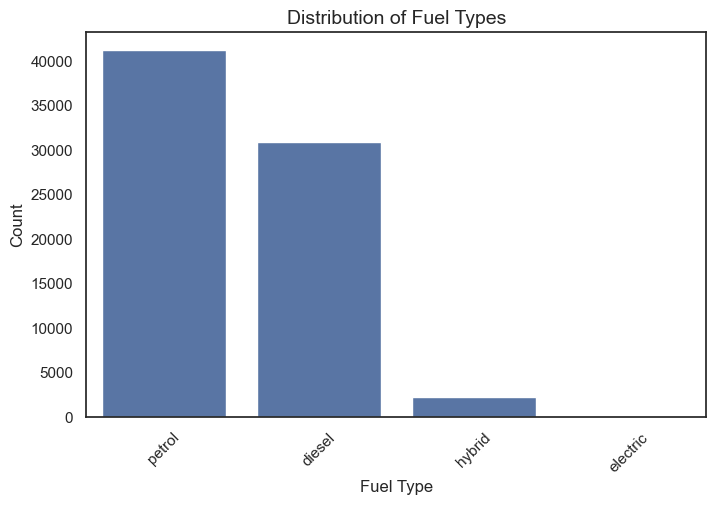

In [79]:
sns.set(style="white")

# Create a countplot to visualize the distribution of 'fuelType'.
plt.figure(figsize=(8, 5))  
sns.countplot(x='fuelType', data=df_train, order=df_train['fuelType'].value_counts().index)

# Add title and labels
plt.title('Distribution of Fuel Types', fontsize=14)
plt.xlabel('Fuel Type', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Rotate x-axis labels.
plt.xticks(rotation=45)
plt.show()

In [80]:
df_train["fuelType"].value_counts()

fuelType
petrol      41181
diesel      30885
hybrid       2225
electric        4
Name: count, dtype: int64

#### FuelType Observations
- 1511 missing values were found.
- 5 categories found when metadata only reported 4 ('other' was converted to nan)
- Typing errors were identified and corrected.
- Petrol is the most common fuel type, followed by diesel.
- Only a very small portion of the dataset is electric, altough they can´t be removed because if it appears a car within this categorie the model will not know how handle that situation, should be looked into later stages.

## 2.7. Mpg

Ckecking Nan values.

In [81]:
# Sum of all Nan values in mpg variable.
df_train['mpg'].isna().sum()

np.int64(7926)

Cheking Inconsistencies.

In [82]:
# Get unique values from the 'mpg' column.
df_train['mpg'].unique()

array([ 11.41726775,  47.9       ,  40.9       ,  65.7       ,
        42.8       ,  60.1       ,  68.9       ,  62.8       ,
        67.3       ,  54.3       ,  57.7       ,          nan,
        56.5       ,  72.4       ,  47.1       ,  44.1       ,
        46.3       ,  32.5       ,  48.7       ,  74.3       ,
        43.5       ,  78.5       ,  51.4       ,  50.4       ,
        67.        ,  28.5       ,  64.2       ,  61.4       ,
        41.5       ,  52.3       ,  53.3       ,  44.8       ,
        35.8       ,  80.7       ,  37.2       ,  49.6       ,
        42.2       ,  45.6       ,  34.        ,  74.4       ,
        29.1       ,  76.3       ,  40.3       ,  58.9       ,
        39.8       ,  55.4       ,  40.4       ,  78.4       ,
        83.1       ,  33.2       ,  34.5       ,  70.6       ,
        35.3       ,  39.2       ,  32.8       ,  34.9       ,
        61.7       ,  30.        , 156.9       ,  36.2       ,
        58.        ,  38.2       ,  69.        ,  37.7 

- No zero values, which would be impossible.
- Most values like 11.4, 47.9, 40.9, 65.7, make sense.
- Negative values (-43.42) are clearly errors.

For this variable, it makes sense to have decimal values, but we don’t need so many. We can round all values to just one decimal place.

In [83]:
# Round all values in the 'mpg' column to one decimal place
df_train['mpg'] = df_train['mpg'].round(1)

Checking negative values.

In [84]:
(df_train['mpg'] < 0).sum()

np.int64(36)

In [85]:
df_train[df_train['mpg'] < 0]

,carID,brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
758,13396,bmw,x1,2019,25480,Semi-Auto,5163,petrol,145.0,-43.4,2.0,86.0,1.0,0.0
2545,14934,bmw,3 series,2019,29500,Automatic,3185,petrol,145.0,-43.4,2.0,97.0,3.0,0.0
5156,14127,bmw,2 series,2020,32450,Semi-Auto,1118,diesel,145.0,-43.4,2.0,37.0,1.0,0.0
6306,14420,bmw,2 series,2015,17799,Automatic,38902,petrol,260.0,-43.4,3.0,33.0,4.0,0.0
7454,12400,bmw,x5,2016,26995,Automatic,46126,diesel,200.0,-43.4,3.0,77.0,2.0,0.0
7577,14603,bmw,2 series,2015,17541,Semi-Auto,26035,petrol,165.0,-43.4,2.0,75.0,3.0,0.0
9800,11181,bmw,1 series,2019,19298,Semi-Auto,10040,diesel,145.0,-43.4,2.0,70.0,3.0,0.0
10107,7781,bmw,3 series,2017,14800,Manual,29968,diesel,30.0,-43.4,2.0,52.0,1.0,0.0
10381,9202,bmw,x1,2016,17000,Automatic,46968,diesel,125.0,-43.4,2.0,82.0,0.0,0.0
11235,10214,bmw,3 series,2014,14500,Automatic,45140,diesel,125.0,-43.4,3.0,77.0,2.0,0.0


All these negative values are the same (-43.4) and belong to BMW cars with different engine sizes. This likely indicates a data entry error, and the correct values could potentially be imputed based on similar BMW models

In [86]:
# Set every mpg value less than 1.5 to NaN.
df_train.loc[df_train['mpg'] < 1.5 , 'mpg'] = np.nan

In [87]:
# New number of Nan values in mpg variable.
df_train['mpg'].isna().sum()

np.int64(7962)

Visualizing the variable mpg on a histogram and boxplot.

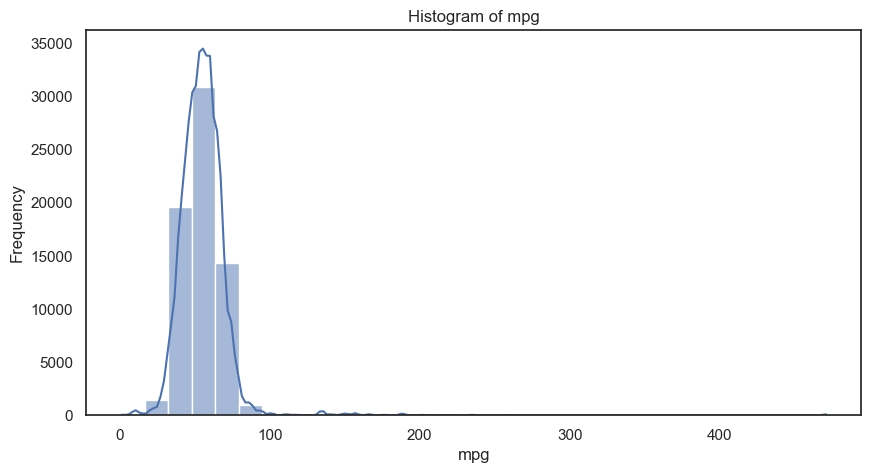

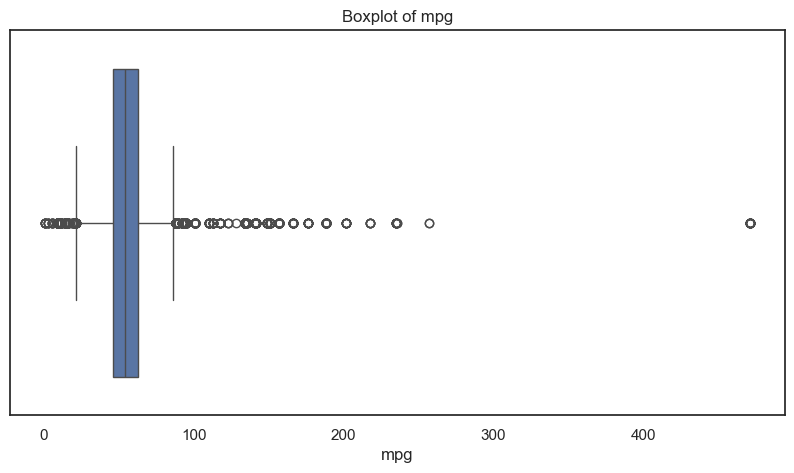

In [88]:
# Histogram.
plt.figure(figsize=(10,5))
sns.histplot(df_train['mpg'], bins=30, kde=True) 
plt.title('Histogram of mpg')
plt.xlabel('mpg')
plt.ylabel('Frequency')
plt.show()

# Boxplot.
plt.figure(figsize=(10,5))
sns.boxplot(x=df_train['mpg'])
plt.title('Boxplot of mpg')
plt.xlabel('mpg')
plt.show()

**Outliers:** 
- The distribution of this variable is highly right skewed with some extreme outliers which give disproportionate leverage to a few samples, hurting linear models and making scaling unstable. 
- The plan is to apply log1p. 
- log1p compresses the long right tail, stabilizes variance, and often linearizes multiplicative

In [89]:
# Inspect highest outlier, is this an error ?
df_train.loc[df_train["mpg"].idxmax()]

carID                 13075
brand                   bmw
model                    i3
year                   2015
price                 15498
transmission      Automatic
mileage               33931
fuelType             hybrid
tax                     0.0
mpg                   470.8
engineSize              0.0
paintQuality%          31.0
previousOwners          4.0
hasDamage               0.0
Name: 4101, dtype: object

In [90]:
df_train[(df_train["brand"] == "bmw") & (df_train["model"] == "i3")]

,carID,brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
4101,13075,bmw,i3,2015,15498,Automatic,33931,hybrid,0.0,470.8,0.000000,31.0,4.00000,0.0
5278,12640,bmw,i3,2017,19500,Automatic,23956,NaN,135.0,470.8,0.600000,53.0,1.00000,0.0
6978,12786,bmw,i3,2015,17400,Automatic,29465,electric,0.0,470.8,3.822758,67.0,2.00000,0.0
18261,8993,bmw,i3,2016,18999,Automatic,9990,NaN,0.0,470.8,0.000000,44.0,0.00000,0.0
18710,12853,bmw,i3,2017,21898,Automatic,10839,hybrid,0.0,470.8,0.000000,31.0,4.00000,0.0
21445,12090,bmw,i3,2016,19490,Automatic,8421,hybrid,0.0,470.8,0.000000,31.0,4.00000,0.0
24883,10653,bmw,i3,2017,19895,Automatic,29851,hybrid,0.0,NaN,0.000000,40.0,0.00000,0.0
24975,13378,bmw,i3,2015,17481,Automatic,9886,hybrid,0.0,470.8,0.000000,44.0,0.00000,0.0
29581,12269,bmw,i3,2017,19980,Automatic,26965,hybrid,140.0,470.8,0.000000,81.0,3.00000,0.0
33383,10695,bmw,i3,2017,21494,Automatic,<NA>,hybrid,135.0,470.8,0.000000,54.0,1.00000,0.0


- This inspection turns out to be very usefull:
      1) this value of mpg is not an error it´s a caractheristic of the model;
      2) this car is the proof that transmission/fuelType NaN values can be in some cases imputed by mode

#### Mpg Observations

- Initial missing values: 7926 NaN
- Found very high outliers: 470.8
- Found negative vales: -43.42. All from the same brand - BMW
- Updated missing values: 7962 NaN

## 2.8. EngineSize

Ckecking Nan values.

In [91]:
# Sum of all Nan values in engineSizeS variable.
df_train['engineSize'].isna().sum()

np.int64(1516)

Cheking Inconsistencies.

In [92]:
# Get unique values from the 'engineSize' column.
df_train['engineSize'].unique()

array([ 2.        ,  1.5       ,  1.        ,  1.4       ,  1.6       ,
               nan,  1.2       ,  3.        ,  1.8       ,  2.1       ,
        1.3       ,  0.7395339 ,  0.        ,  2.3       ,  1.1       ,
        4.        ,  1.7       ,  2.98579344,  2.2       ,  2.5       ,
        2.61964142, -0.1034928 ,  2.78177621,  2.63120047,  3.72371217,
        0.15452932,  4.2       ,  3.2       ,  2.9       ,  2.8       ,
        0.31340658,  2.06411863,  3.73923548,  2.4       ,  0.18642488,
        2.6631132 ,  5.2       ,  0.19146242,  5.        ,  0.30707394,
        0.37112737,  4.4       ,  6.2       ,  3.82275785,  1.9       ,
        0.6       ,  6.6       ,  5.5       ,  3.5       ,  4.7       ,
        0.16286595,  2.7       ,  3.6       ,  2.6       ,  4.3       ,
        5.4       ,  4.5       ,  4.1       ,  6.        ])

These very small engine sizes (0.154 L, 0.186 L, 0.191 L, 0.307 L) are unrealistic. They are likely errors caused by wrong units, misplaced decimals, or data entry mistakes.

It also doesn’t make sense to have some values with so many decimal places. Let’s round them all to just one decimal place.

In [93]:
# Rounding all values to just one decimal place.
df_train['engineSize'] = df_train['engineSize'].round(1)

In [94]:
sorted(df_train['engineSize'].dropna().unique())

[np.float64(-0.1),
 np.float64(0.0),
 np.float64(0.2),
 np.float64(0.3),
 np.float64(0.4),
 np.float64(0.6),
 np.float64(0.7),
 np.float64(1.0),
 np.float64(1.1),
 np.float64(1.2),
 np.float64(1.3),
 np.float64(1.4),
 np.float64(1.5),
 np.float64(1.6),
 np.float64(1.7),
 np.float64(1.8),
 np.float64(1.9),
 np.float64(2.0),
 np.float64(2.1),
 np.float64(2.2),
 np.float64(2.3),
 np.float64(2.4),
 np.float64(2.5),
 np.float64(2.6),
 np.float64(2.7),
 np.float64(2.8),
 np.float64(2.9),
 np.float64(3.0),
 np.float64(3.2),
 np.float64(3.5),
 np.float64(3.6),
 np.float64(3.7),
 np.float64(3.8),
 np.float64(4.0),
 np.float64(4.1),
 np.float64(4.2),
 np.float64(4.3),
 np.float64(4.4),
 np.float64(4.5),
 np.float64(4.7),
 np.float64(5.0),
 np.float64(5.2),
 np.float64(5.4),
 np.float64(5.5),
 np.float64(6.0),
 np.float64(6.2),
 np.float64(6.6)]

Anything with negative or values below 0.5 are errors. Therefore, we will replace these values with NaN.

In [95]:
df_train.loc[df_train['engineSize'] <= 0.5, 'engineSize'] = np.nan

In [96]:
# Inspecting high outliers, are these wrong values ?
df_train.loc[(df_train['engineSize'] > 5.0)]

,carID,brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
2824,5953,audi,r8,2019,137500,Semi-Auto,10,petrol,150.0,21.4,5.2,70.0,1.0,0.0
4049,38980,mercedes,c class,2013,23000,Semi-Auto,43442,petrol,NaN,NaN,6.2,76.0,0.0,0.0
5047,46372,mercedes,c class,2013,22995,Semi-Auto,49964,petrol,NaN,23.0,6.2,78.0,3.0,0.0
5630,9197,bmw,7 series,2017,57000,Automatic,11297,petrol,145.0,22.1,6.6,68.0,1.0,0.0
6030,42286,mercedes,c class,2014,26998,Semi-Auto,24175,petrol,NaN,NaN,6.2,93.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70337,39752,mercedes,c class,2014,21495,Automatic,56444,petrol,NaN,NaN,6.2,52.0,3.0,0.0
70579,39725,mercedes,gle class,2017,52999,Semi-Auto,23000,petrol,145.0,23.9,5.5,34.0,1.0,0.0
70612,46040,mercedes,gls class,2017,53000,utomatic,45239,petrol,150.0,23.0,5.5,89.0,4.0,0.0
70754,34980,mercedes,s class,2014,41980,utomatic,26000,petrol,555.0,28.0,5.5,92.0,1.0,0.0


- According to sources like https://www.carwow.co.uk/guides/choosing/what-engine-size-do-i-need-0521? , cars above the 3.0 are high end models but realistic.
- Above 6.0 are a real stretch, but in cases like the mercedes c class amg it corresponds exactly to 6.2 https://en.wikipedia.org/wiki/Mercedes-Benz_M156_engine, which corresponds to the cars with this specification.

In [97]:
df_train.loc[(df_train['engineSize'] > 6.0)]

,carID,brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
4049,38980,mercedes,c class,2013,23000,Semi-Auto,43442,petrol,NaN,NaN,6.2,76.0,0.0,0.0
5047,46372,mercedes,c class,2013,22995,Semi-Auto,49964,petrol,NaN,23.0,6.2,78.0,3.0,0.0
5630,9197,bmw,7 series,2017,57000,Automatic,11297,petrol,145.000000,22.1,6.6,68.0,1.0,0.0
6030,42286,mercedes,c class,2014,26998,Semi-Auto,24175,petrol,NaN,NaN,6.2,93.0,2.0,0.0
9759,39900,mercedes,c class,2014,28990,Semi-Auto,19562,petrol,NaN,NaN,6.2,83.0,0.0,0.0
13474,39852,mercedes,s class,2010,26990,Automatic,38000,petrol,570.000000,19.5,6.2,76.0,4.0,0.0
14216,35612,mercedes,c class,2013,23990,Automatic,<NA>,petrol,570.000000,23.5,6.2,44.0,2.0,0.0
17208,36196,mercedes,c class,2014,25885,Semi-Auto,86706,petrol,NaN,NaN,6.2,31.0,0.0,0.0
20432,35538,mercedes,c class,<NA>,22995,Semi-Auto,49964,petrol,326.028233,NaN,6.2,58.0,3.0,0.0
20916,44937,mercedes,c class,2013,21999,Automatic,41866,petrol,570.000000,23.5,6.2,80.0,0.0,0.0


In [98]:
# Cheking final number of Nan Values.
df_train['engineSize'].isna().sum()

np.int64(1780)

Visualizing the variable engineSize on a histogram and boxplot.

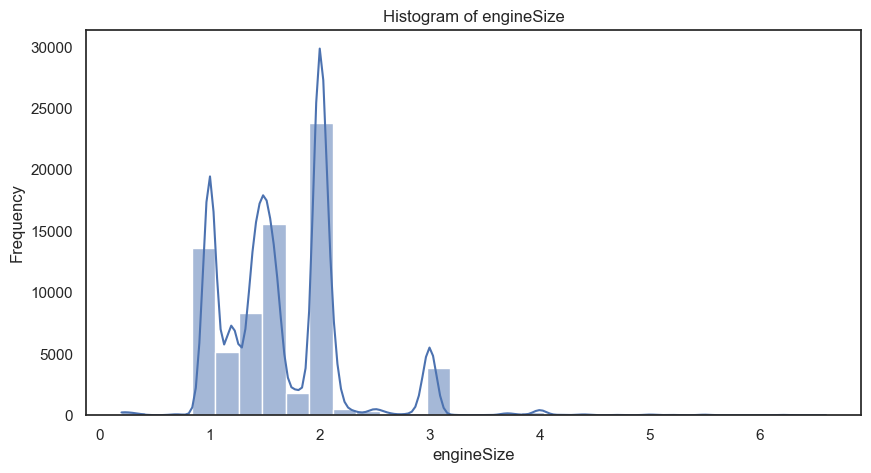

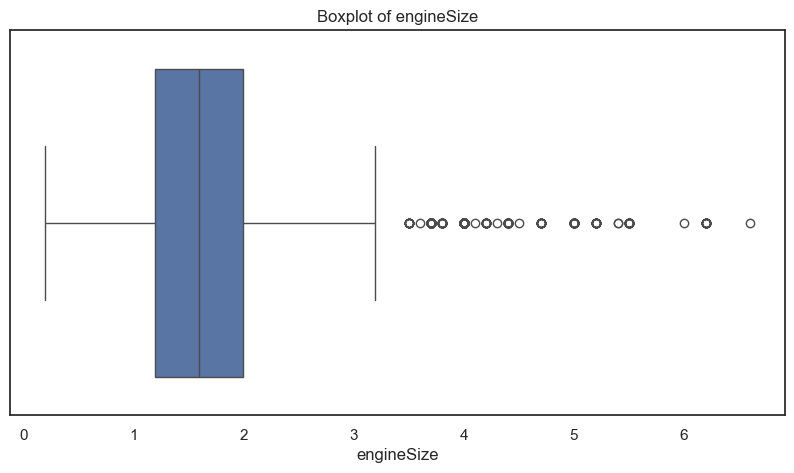

In [99]:
# Histogram.
plt.figure(figsize=(10,5))
sns.histplot(df_train['engineSize'], bins=30, kde=True) 
plt.title('Histogram of engineSize')
plt.xlabel('engineSize')
plt.ylabel('Frequency')
plt.show()

# Boxplot.
plt.figure(figsize=(10,5))
sns.boxplot(x=df_train['engineSize'])
plt.title('Boxplot of engineSize')
plt.xlabel('engineSize')
plt.show()

**Outliers:** 
- The distribution of this variable is highly right skewed with some extreme outliers which give disproportionate leverage to a few samples, hurting linear models and making scaling unstable. 
- The plan is to apply log1p. 
- log1p compresses the long right tail, stabilizes variance, and often linearizes multiplicative

#### EngineSize Observations 

- Initially, 1516 NaN values were present in the engineSize column.
- Unrealistic values (equal or below 0.0 L) were replaced with NaN.
- The final number of NaN values is 1718.
- Values above 3.5 L are considered outliers, representing rarer car models.

## 2.9. PreviousOwners

Ckecking Nan values.

In [100]:
# Sum of all Nan values in previousOwners variable.
df_train['previousOwners'].isna().sum()

np.int64(1550)

Cheking Inconsistencies.

In [101]:
# Get unique values from the 'previousOwners' column.
df_train['previousOwners'].unique()

array([ 4.        ,  1.        , -2.34030622,  3.        ,  0.        ,
        2.        ,         nan, -2.34565   ,  6.25837066, -2.33512284,
        6.22789796,  6.25823052,  6.23017958, -2.33936045,  6.21772443,
        6.24583495, -2.29943868, -2.34010209, -2.31225953,  6.2482512 ,
       -2.31733109,  6.23308217,  6.24177863, -2.33744529])

- It doesn’t make sense for the number of previous owners to be a float.
- We need to round values to the nearest integer and change the dtype to Int64.
- Negative numbers of previous owners also don’t make sense.
- 0 previous ownres can make sense since the car can be totally new.

In [102]:
# Round to nearest integer.
df_train['previousOwners'] = df_train['previousOwners'].round(0)

In [103]:
df_train['previousOwners'].unique()

array([ 4.,  1., -2.,  3.,  0.,  2., nan,  6.])

In [104]:
# Checking the negatve number of previous owners.
(df_train['previousOwners'] < 0).sum()

np.int64(371)

In [105]:
# Replace negative values with NaN.
df_train['previousOwners'] = df_train['previousOwners'].apply(lambda x: np.nan if x < 0 else x)

In [106]:
df_train['previousOwners'].unique()

array([ 4.,  1., nan,  3.,  0.,  2.,  6.])

Fixing dtype from float to Int64

In [107]:
# Convert the column to integer type (Int64 allows NaN values).
df_train['previousOwners'] = df_train['previousOwners'].astype('Int64')

In [108]:
# Cheking final number of Nan Values.
df_train['previousOwners'].isna().sum()

np.int64(1921)

Visualizing the variable previousOwners on a histogram and boxplot.

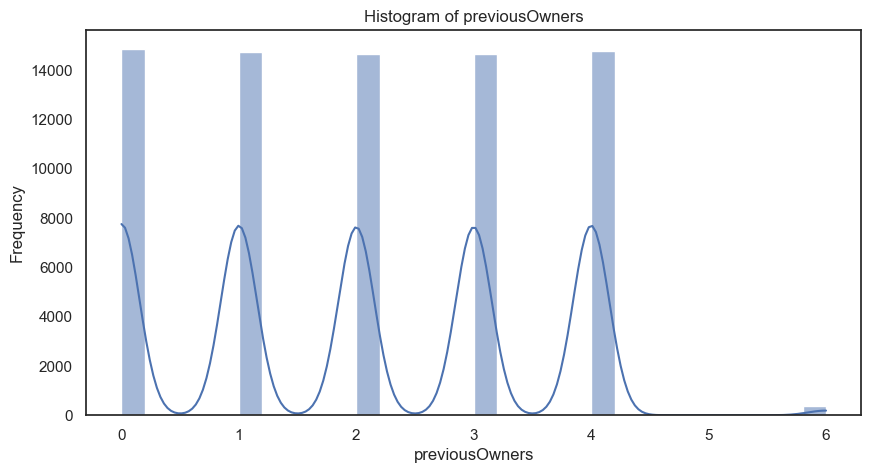

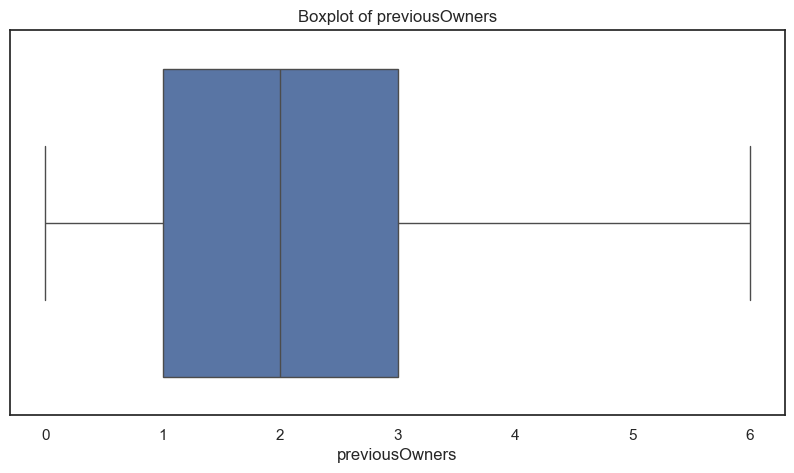

In [109]:
# Histogram.
plt.figure(figsize=(10,5))
sns.histplot(df_train['previousOwners'], bins=30, kde=True) 
plt.title('Histogram of previousOwners')
plt.xlabel('previousOwners')
plt.ylabel('Frequency')
plt.show()

# Boxplot.
plt.figure(figsize=(10,5))
sns.boxplot(x=df_train['previousOwners'])
plt.title('Boxplot of previousOwners')
plt.xlabel('previousOwners')
plt.show()

Visualizing the variable engineSize in a countplot.

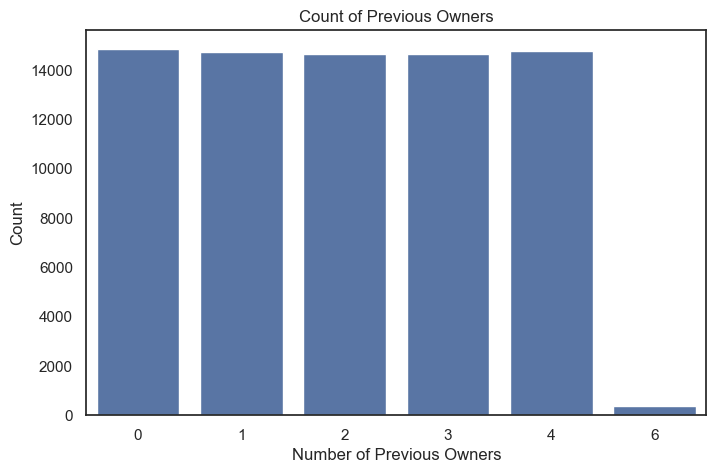

In [110]:
# Plot countplot
plt.figure(figsize=(8, 5))
sns.countplot(x='previousOwners', data=df_train.dropna(subset=['previousOwners']))
plt.title('Count of Previous Owners')
plt.xlabel('Number of Previous Owners')
plt.ylabel('Count')
plt.show()

In [111]:
df_train['previousOwners'].unique()

<IntegerArray>
[4, 1, <NA>, 3, 0, 2, 6]
Length: 7, dtype: Int64

#### PreviousOwners Observations

- Initially, previousOwners had 1,550 NaN values.
- Negative values were found, which are impossible, so they were replaced with NaN.
- The new total of NaN values is 1,921.
- The data type was changed from float to Int64.
- No outliers were detected; all values appear realistic.
- Most cars have 0, 1, 2, 3, or 4 previous owners, well distributed.
- Very few cars have 6 previous owners.

## 2.10. HasDamage

In [112]:
# Sum of all Nan values in hasDamage variable.
df_train['hasDamage'].isna().sum()

np.int64(1548)

In [113]:
df_train['hasDamage'].value_counts(dropna=False, normalize=True) * 100

hasDamage
0.0    97.962434
NaN     2.037566
Name: proportion, dtype: float64

In [114]:
df_train = df_train.drop(columns=['hasDamage'])

#### Has Damage Observations
- No car is marked with damage
- Since 98% of cars have the same value for this variable, it has no predicting power so should be removed

## 2.11. Price

Ckecking Nan values.

In [115]:
# Sum of all Nan values of price variable.
df_train['price'].isna().sum()

np.int64(0)

In [116]:
df_train['price'].describe()

count     75973.000000
mean      16881.889553
std        9736.926322
min         450.000000
25%       10200.000000
50%       14699.000000
75%       20950.000000
max      159999.000000
Name: price, dtype: float64

In [117]:
df_train['price'].head(30)

0     22290
1     13790
2     24990
3     12500
4     22995
5      8199
6     16089
7      7500
8     15999
9     15300
10    11998
11    24109
12    17799
13    13295
14    13990
15    19491
16     6990
17    19995
18    18997
19    28995
20     7500
21    31299
22     8995
23    45995
24    12299
25    26176
26    11295
27    57895
28     6750
29    17990
Name: price, dtype: int64

Checking the statitics.

In [118]:
df_train['price'].describe()

count     75973.000000
mean      16881.889553
std        9736.926322
min         450.000000
25%       10200.000000
50%       14699.000000
75%       20950.000000
max      159999.000000
Name: price, dtype: float64

Eliminating missing values

In [119]:
df_train = df_train.dropna(subset=['price'])

Visualizing 'price' on a histogram and boxplot.

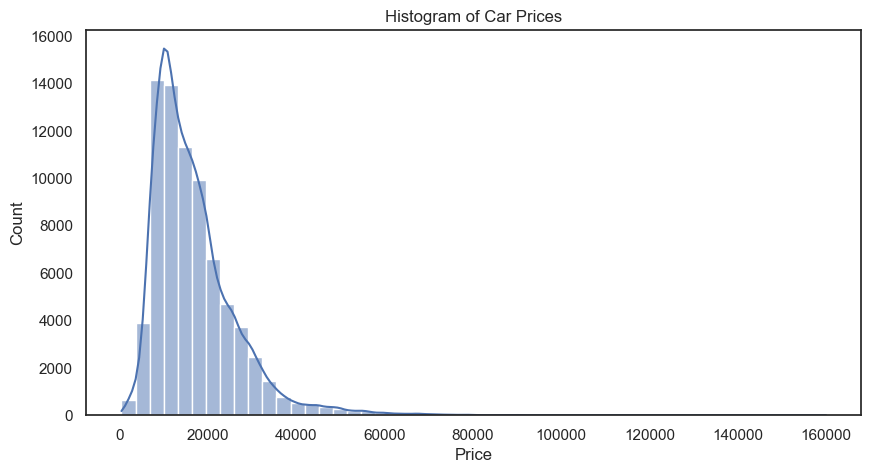

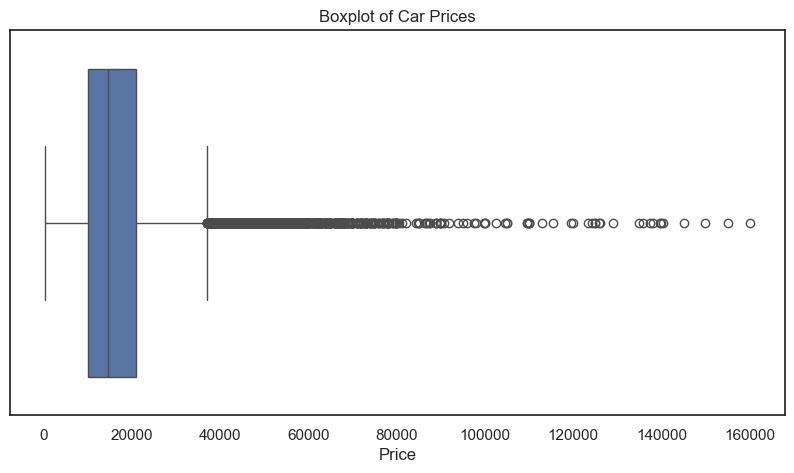

In [120]:
# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(df_train['price'], bins=50, kde=True)
plt.title('Histogram of Car Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

# Boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_train['price'])
plt.title('Boxplot of Car Prices')
plt.xlabel('Price')
plt.show()

**Outliers:** 
- The distribution of this variable is highly right skewed with some extreme outliers which give disproportionate leverage to a few samples, hurting linear models and making scaling unstable. 
- The plan is to apply log1p. 
- log1p compresses the long right tail, stabilizes variance, and often linearizes multiplicative

#### Price Observations
- It does not have missing values
- Prices range from 450 to 159 999 dolars, with a mean of ~16 885 dolars and median of 14 698 dolars.
- A right-skewed price distribution was observed, with a small number of premium cars.
- These high-value vehicles are likely to be harder to predict accurately, as the model will be primarily trained on mid-range prices

## 2.12. Transmission

Checking Nan values.

In [121]:
# Sum of all Nan values of transmission variable.
df_train['transmission'].isna().sum()

np.int64(1522)

Checking Inconsistencies.

In [122]:
df_train['transmission'].unique()

array(['Semi-Auto', 'Manual', 'anual', 'Semi-Aut', 'Automatic', 'manual',
       nan, 'unknown', 'Manua', 'AUTOMATIC', 'MANUAL', 'semi-auto',
       ' Manual ', 'automatic', 'emi-Auto', 'SEMI-AUTO', 'SEMI-AUT',
       'Automati', 'ANUAL', 'utomatic', 'unknow', 'EMI-AUTO', 'manua',
       'anua', 'emi-Aut', 'MANUA', 'emi-auto', 'UTOMATIC', ' manual ',
       ' MANUAL ', 'UNKNOWN', 'nknown', 'automati', 'Other', 'semi-aut',
       ' Manual', 'AUTOMATI', 'utomati', 'Manual ', 'manual ', 'nknow'],
      dtype=object)

Several typing errors were found—missing letters, inconsistent capitalization, etc. We will remove extra spaces and convert everything to lowercase.

In [123]:
# Remove leading/trailing spaces and lowercase all entries.
df_train['transmission'] = df_train['transmission'].str.strip().str.lower()

In [124]:
# Cheking all unique values after removing spaces and lowercase.
sorted(df_train['transmission'].dropna().astype(str).unique())

['anua',
 'anual',
 'automati',
 'automatic',
 'emi-aut',
 'emi-auto',
 'manua',
 'manual',
 'nknow',
 'nknown',
 'other',
 'semi-aut',
 'semi-auto',
 'unknow',
 'unknown',
 'utomati',
 'utomatic']

In [125]:
transmission_values = ["automatic", "manual", "semi-auto", "other", "unknown"]
df_train["transmission"] = df_train["transmission"].apply(lambda x: fuzzy_to_domain(x, domain=transmission_values))

In [126]:
# Replace all 'unknown' and 'other' values in the 'transmission' column with NaN
df_train['transmission'] = df_train['transmission'].replace('unknown', np.nan)
df_train['transmission'] = df_train['transmission'].replace('other', np.nan)

In [127]:
# Checking the new number of Nan values.
df_train['transmission'].isna().sum()

np.int64(2263)

Visualizing 'transmission' on a countplot.

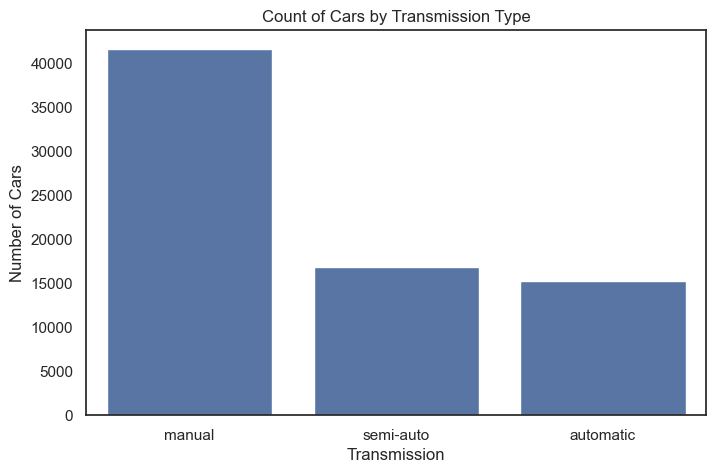

In [128]:
# Plot countplot of transmission types
plt.figure(figsize=(8,5))
sns.countplot(data=df_train, x='transmission', order=df_train['transmission'].value_counts().index)
plt.title('Count of Cars by Transmission Type')
plt.xlabel('Transmission')
plt.ylabel('Number of Cars')
plt.show()

#### Transmission Observations
- Initially found 1512 missing values.
- Typing errors were corrected and extra spaces removed.
- Final number of NaN values: 2263.
- Entries with 'unknow' or 'other' were converted to NaN.
- Most cars have Manual transmission, followed by Semi-Auto and Automatic.

## 2.13. PaintQuality%

Checking Nan values.

In [129]:
# Check NaN values for paintQuality# column.
df_train['paintQuality%'].isna().sum()

np.int64(1524)

Checking Inconsistencies.

In [130]:
# Round all remaining values to the nearest integer.
df_train['paintQuality%'] = df_train['paintQuality%'].round()

In [131]:
# Convert the column dtype to Int64 to handle integers with NaN values.
df_train['paintQuality%'] = df_train['paintQuality%'].astype('Int64')

In [132]:
df_train['paintQuality%'].unique()

<IntegerArray>
[  63,   50,   56,   97,   74,   75,   59,   85,   35,   68,   45,   30,   69,
   53,   57,   40,   60,   94,   33,   51,   47,   87,   61,   83,   95,   46,
   54,   80,   77,   90,   91,   71,   44,   38,   64,   55,   66,   82,   41,
   81,   79,   72,   34,   88, <NA>,   43,   31,   32,   96,   84,   70,   86,
   92,   52,   39,   42,   73,   78,   37,   65,   93,   89,   99,   36,   62,
  125,    3,   67,  126,   76,   48,   49,   98,   58,    2]
Length: 75, dtype: Int64

In [133]:
# Check NaN values again.
df_train['paintQuality%'].isna().sum()

np.int64(1524)

Visualizing 'paintQuality%' on a histogram and boxplot.

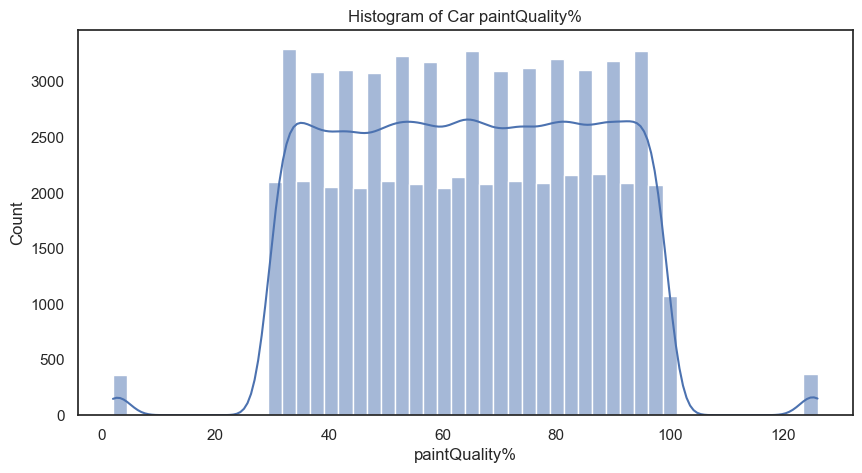

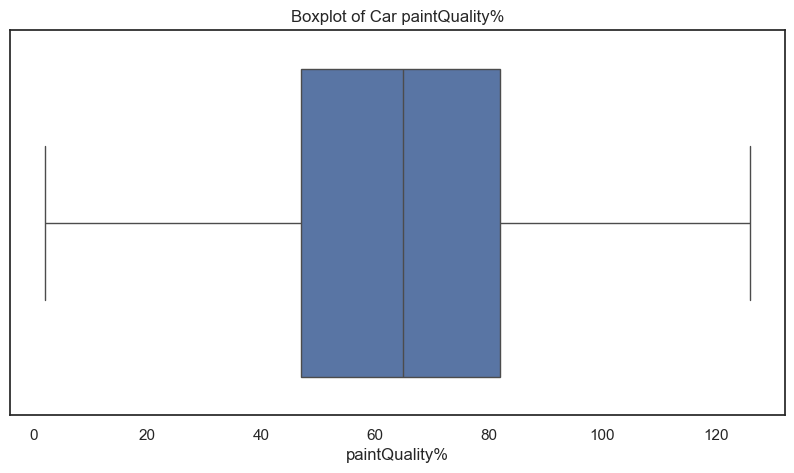

In [134]:
# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(df_train['paintQuality%'], bins=50, kde=True)
plt.title('Histogram of Car paintQuality%')
plt.xlabel('paintQuality%')
plt.ylabel('Count')
plt.show()

# Boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_train['paintQuality%'])
plt.title('Boxplot of Car paintQuality%')
plt.xlabel('paintQuality%')
plt.show()

#### PaintQuality% Observations
- 1524 NaN values were detected.
- Some values had decimals, so all were rounded to the nearest integer and dtype changed from float to Int64.
- The histogram and boxplot show a well-distributed variable with no outliers.

## Other

In [135]:
(df_train.isna().any(axis=1).mean() * 100).round(2)

np.float64(28.25)

In [136]:
(df_train.isna().mean() * 100).sort_values(ascending=False).round(2)

tax               10.90
mpg               10.48
transmission       2.98
previousOwners     2.53
year               2.43
mileage            2.41
engineSize         2.34
model              2.27
fuelType           2.21
paintQuality%      2.01
brand              0.06
price              0.00
carID              0.00
dtype: float64

# 3. Multivariate Analysis

#### Correlation Matrix for Numeric Variables

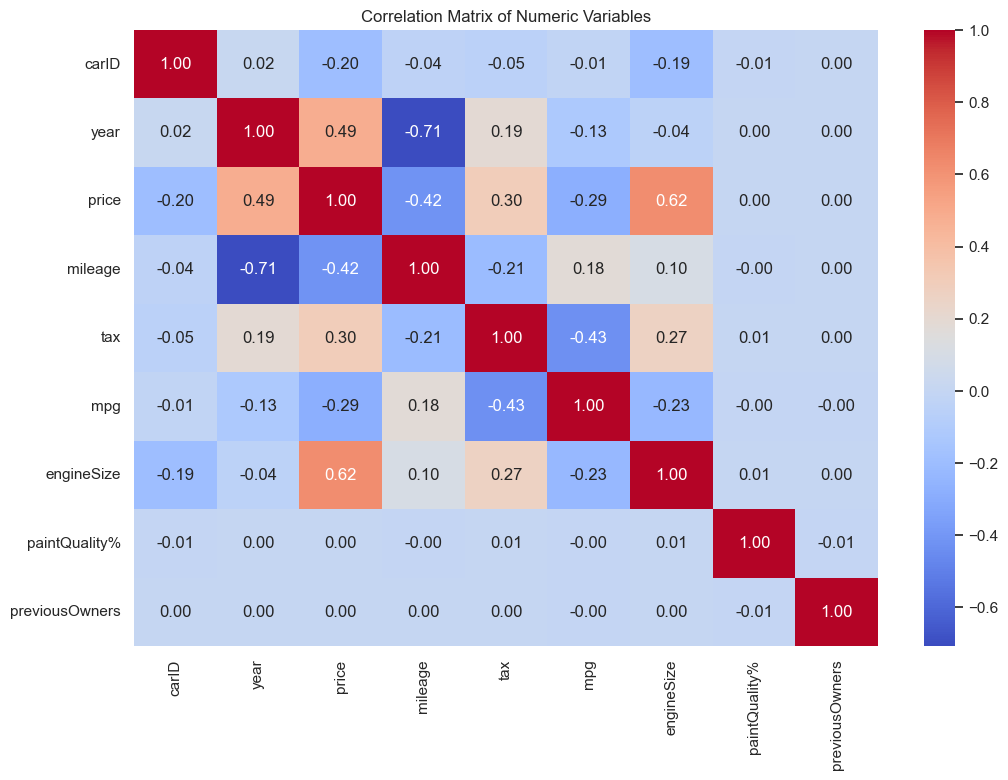

In [137]:
# Select only numeric columns
numeric_cols = df_train.select_dtypes(include=['int64', 'Int64', 'float64']).columns

# Compute correlation matrix
corr_matrix = df_train[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Variables")
plt.show()

- We will start to look into the variables that have 0 correlation with price since those probably are redudant and will be removed

#### Price & Car Id

In [138]:
# carId is just a label identifying each car so not relatable to anything and will be removed
df_train = df_train.drop(columns=['carID'])

#### Price & Previous Owners

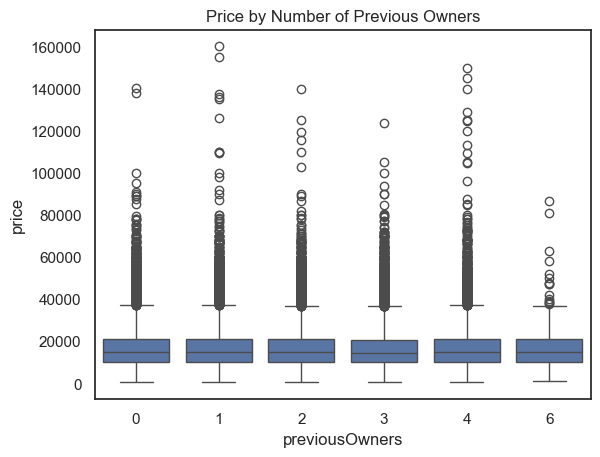

In [139]:
sns.boxplot(x='previousOwners', y='price', data=df_train.dropna(subset=['previousOwners']))
plt.title('Price by Number of Previous Owners')
plt.show()

In [140]:
df_train.groupby('previousOwners')['price'].mean()

previousOwners
0    16854.936824
1    16945.351227
2    16875.898525
3    16789.999590
4    16946.470501
6    16960.363636
Name: price, dtype: float64

- The mean and median prices across ownership levels were nearly identical, and they had 0 correlation, indicating no meaningful predictive relationship

In [141]:
df_train.groupby('previousOwners')['mileage'].mean()

previousOwners
0     23106.40131
1    23581.514459
2    23279.166713
3    23703.534985
4    23174.102144
6    23849.299712
Name: mileage, dtype: Float64

- The variable however could be usefull to predict other missing values like milleage, but that seems also not to be the case since the correlation between this and all other variables is 0

In [142]:
# removing previousOwners because of the reasons pointed before
df_train = df_train.drop(columns=['previousOwners'])

#### Price & Paint Quality

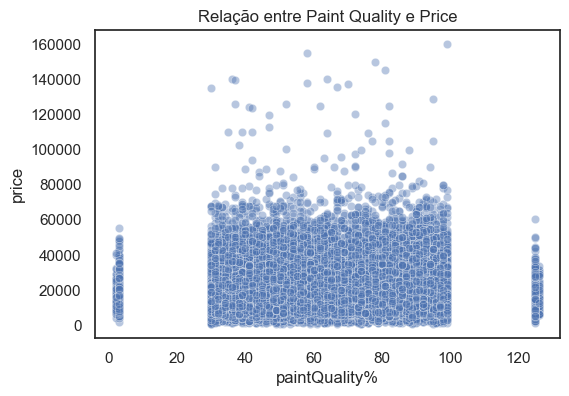

In [143]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='paintQuality%', y='price', data=df_train, alpha=0.4)
plt.title('Relação entre Paint Quality e Price')
plt.show()

In [144]:
df_train = df_train.drop(columns=['paintQuality%'])

- The scenario is equal to before, paint quality has 0 correlation with all variables, its just noise, got removed

#### Price & Transmission Type

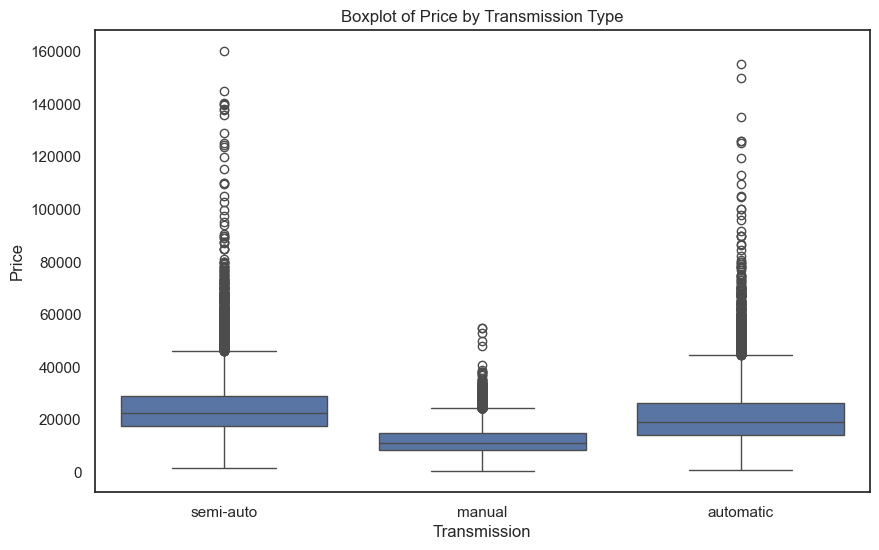

In [145]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='transmission', y='price', data=df_train)
plt.title("Boxplot of Price by Transmission Type")
plt.xlabel("Transmission")
plt.ylabel("Price")
plt.show()

- Manual cars are cheaper than Semi-Auto and Automatic in geral.
- Semi-Auto and Automatic cars can reach very high prices, up to 150,000, while Manual cars rarely exceed 60,000.

#### Price & Year 

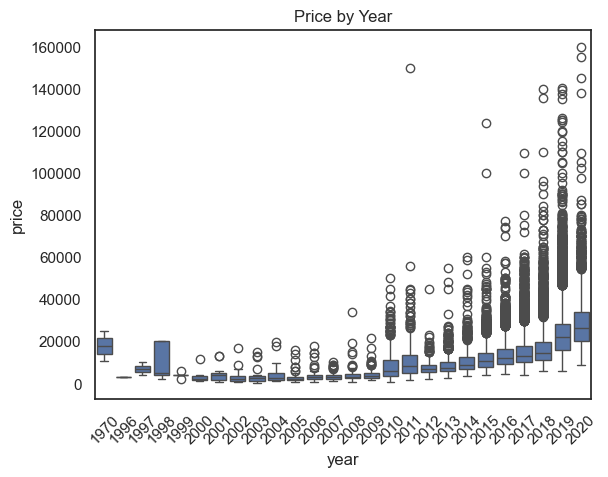

In [146]:
sns.boxplot(x='year', y='price', data=df_train.dropna(subset=['year']))
plt.title('Price by Year')
plt.xticks(rotation=45)
plt.show()

#### Price & Mileage

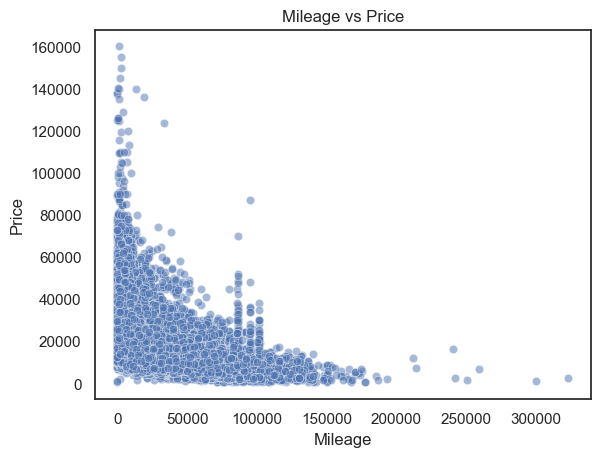

In [147]:
sns.scatterplot(x='mileage', y='price', data=df_train, alpha=0.5)
plt.title('Mileage vs Price')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

- Higher mileage generally corresponds to lower prices, confirming the negative correlation
- The dataset contains a high proportion of vehicles with very low mileage

#### Price & Engine Size

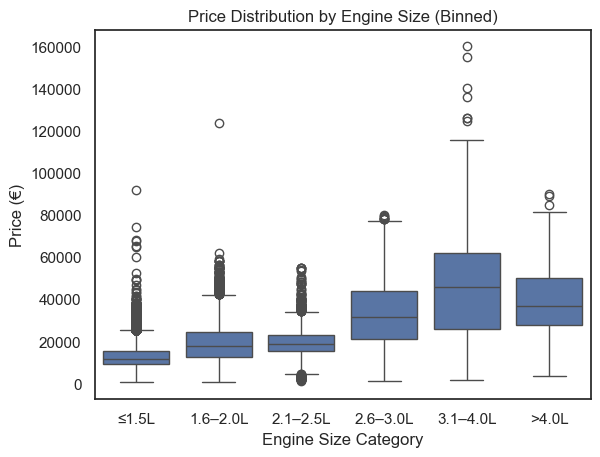

In [148]:
engine_bin = pd.cut(
    df_train['engineSize'],
    bins=[0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0],
    labels=['≤1.5L', '1.6–2.0L', '2.1–2.5L', '2.6–3.0L', '3.1–4.0L', '>4.0L']
)

sns.boxplot(x=engine_bin, y='price', data=df_train)
plt.title('Price Distribution by Engine Size (Binned)')
plt.xlabel('Engine Size Category')
plt.ylabel('Price (€)')
plt.show()


- There is an upward trend in vehicle price across engine size categories.
- Median prices and variability both increase with engine capacity, particularly above 2.5
- Above >4L the median price slightly decreases

#### Price & Brand

brand
mercedes    24466.408098
audi        22887.403485
bmw         22674.551578
vw          16869.758608
skoda       14239.351277
hyundai     12799.170244
ford        12583.957214
toyota      12466.967762
opel        10376.526051
Name: price, dtype: float64


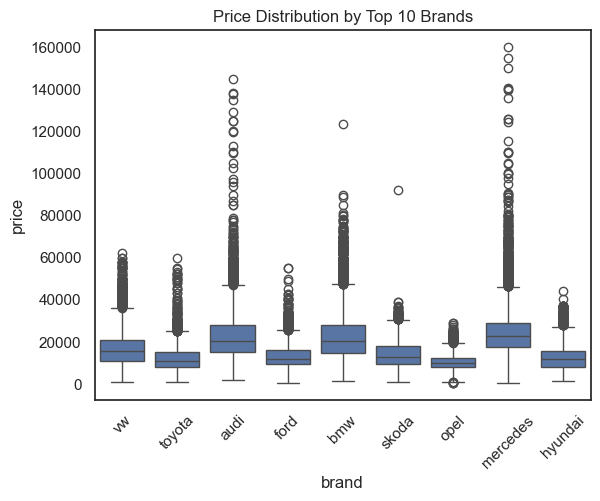

In [149]:
# Average price per brand
brand_price = df_train.groupby('brand')['price'].mean().sort_values(ascending=False)
print(brand_price.head(10))

# Boxplot of price by brand (top 10 brands by count)
top_brands = df_train['brand'].value_counts().head(10).index
sns.boxplot(x='brand', y='price', data=df_train[df_train['brand'].isin(top_brands)])
plt.title('Price Distribution by Top 10 Brands')
plt.xticks(rotation=45)
plt.show()

- Premium brands such as Audi, BMW, and Mercedes exhibit higher median prices and greater variability
- Toyota, Opel, and Hyundai display lower and more homogeneous prices
- Brand can be a strong categorical predictor of vehicle price

#### Price & fuel type

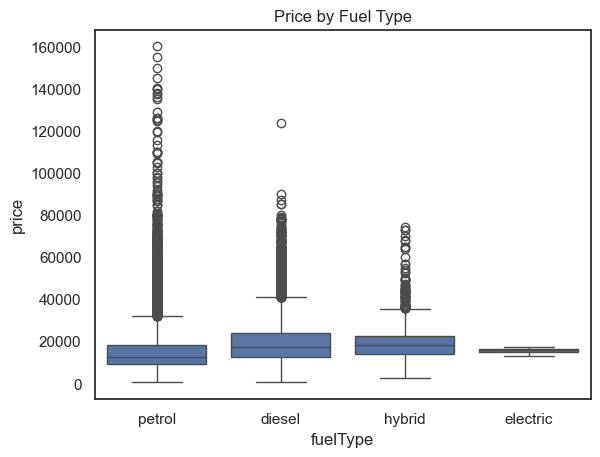

In [150]:
# Price distribution by fuel type
sns.boxplot(x='fuelType', y='price', data=df_train)
plt.title('Price by Fuel Type')
plt.show()

# 4. Preprocessing

In [151]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         75930 non-null  object 
 1   model         74252 non-null  object 
 2   year          74124 non-null  Int64  
 3   price         75973 non-null  int64  
 4   transmission  73710 non-null  object 
 5   mileage       74141 non-null  Int64  
 6   fuelType      74295 non-null  object 
 7   tax           67691 non-null  float64
 8   mpg           68011 non-null  float64
 9   engineSize    74193 non-null  float64
dtypes: Int64(2), float64(3), int64(1), object(4)
memory usage: 5.9+ MB


### Missing Data

In [152]:
miss = df_train.isna().sum()
mv = pd.DataFrame({"missing": miss[miss>0], "missing_%": (miss[miss>0]/len(df)*100).round(2)}).sort_values("missing_%", ascending=False)
if not mv.empty:
    print("\nMissing-values summary (non-zero):")
    print(mv.head(20))


Missing-values summary (non-zero):
              missing  missing_%
tax              8282      10.90
mpg              7962      10.48
transmission     2263       2.98
year             1849       2.43
mileage          1832       2.41
engineSize       1780       2.34
model            1721       2.27
fuelType         1678       2.21
brand              43       0.06


**Plan**: Median imputation for numeric, most_frequent for categoricals.

### Feature Engineering

#### car_age

As stated before we created a new variable car_age because it has a more linear relation to depreciation than raw year.

In [153]:
df_train["car_age"] = 2020 - df_train["year"]

We can drop year as from now on we'll be using car_age

In [154]:
df_train = df_train.drop(columns=['year'])

Visualization of new variable car_age

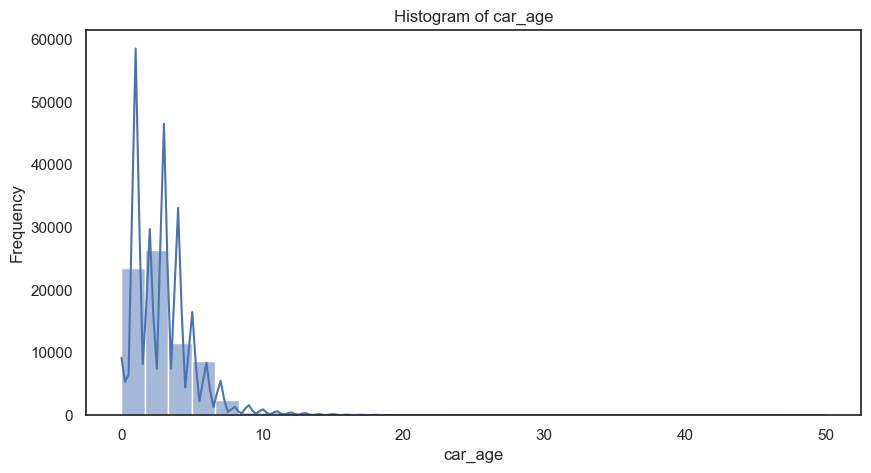

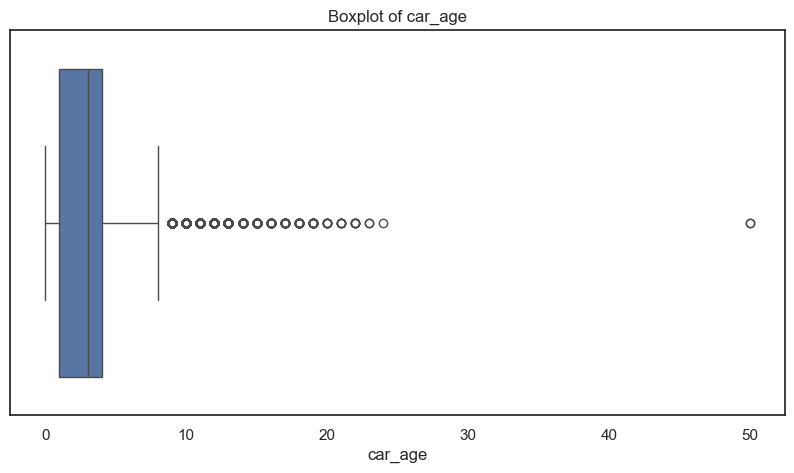

In [155]:
# Histogram.
plt.figure(figsize=(10,5))
sns.histplot(df_train['car_age'], bins=30, kde=True) 
plt.title('Histogram of car_age')
plt.xlabel('car_age')
plt.ylabel('Frequency')
plt.show()

# Boxplot.
plt.figure(figsize=(10,5))
sns.boxplot(x=df_train['car_age'])
plt.title('Boxplot of car_age')
plt.xlabel('car_age')
plt.show()

In [156]:
df_train[df_train["car_age"] > 50]

,brand,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,car_age


**Outliers:** 
- The distribution of this variable is highly right skewed with some extreme outliers which give disproportionate leverage to a few samples, hurting linear models and making scaling unstable. 
- The plan is to apply log1p. 
- log1p compresses the long right tail, stabilizes variance, and often linearizes multiplicative

#### mileage_per_year

We created mileage_per_year to capture use-intensity, in order to separate “old but barely used” from “recent but heavily used.”

In [157]:
df_train["mileage_per_year"] = df_train["mileage"] / df_train["car_age"].replace({0: 1})

Visualization of new variable car_age

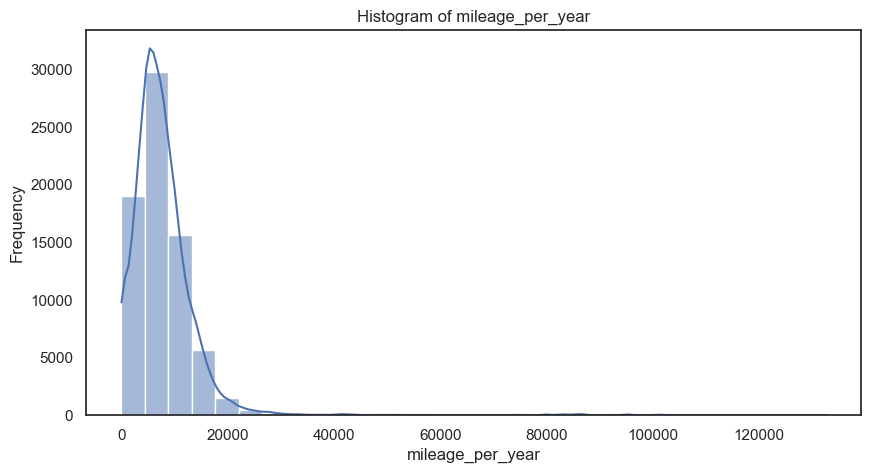

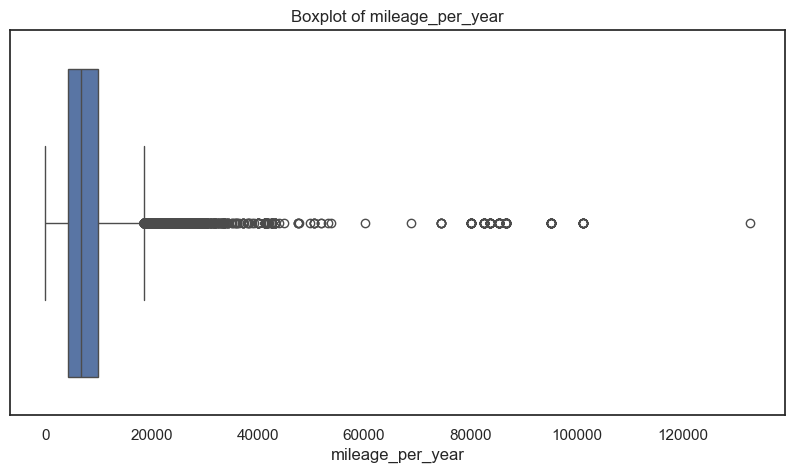

In [158]:
# Histogram.
plt.figure(figsize=(10,5))
sns.histplot(df_train['mileage_per_year'], bins=30, kde=True) 
plt.title('Histogram of mileage_per_year')
plt.xlabel('mileage_per_year')
plt.ylabel('Frequency')
plt.show()

# Boxplot.
plt.figure(figsize=(10,5))
sns.boxplot(x=df_train['mileage_per_year'])
plt.title('Boxplot of mileage_per_year')
plt.xlabel('mileage_per_year')
plt.show()

**Outliers:** 
- The distribution of this variable is highly right skewed with some extreme outliers which give disproportionate leverage to a few samples, hurting linear models and making scaling unstable. 
- The plan is to apply log1p. 
- log1p compresses the long right tail, stabilizes variance, and often linearizes multiplicative

### Data Scaling | Dealing with Categorical Features | Outliers

In [159]:
class RareLabelGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, min_prop=0.005, column=None):
        self.min_prop = min_prop
        self.column = column
        self.keep_values_ = None
    def fit(self, X, y=None):
        s = X if isinstance(X, pd.Series) else pd.Series(X.iloc[:,0] if hasattr(X, "iloc") else X[:,0])
        vc = s.value_counts(dropna=False)
        total = len(s)
        keep = vc[vc / total >= self.min_prop].index
        self.keep_values_ = set(keep.tolist())
        return self
    def transform(self, X):
        s = X if isinstance(X, pd.Series) else pd.Series(X.iloc[:,0] if hasattr(X, "iloc") else X[:,0])
        return pd.DataFrame(np.where(s.isin(self.keep_values_), s, "Other"),
                            columns=[self.column if self.column else "col"])

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column): self.column = column
    def fit(self, X, y=None): return self
    def transform(self, X): return pd.DataFrame(X[self.column])

class CustomWinsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, variables, lower_bound=0.01, upper_bound=0.99):
        self.variables = variables
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.limits_ = {}

    def fit(self, X, y=None):
        for var in self.variables:
            if var in X.columns:
                lower_limit = X[var].quantile(self.lower_bound)
                upper_limit = X[var].quantile(self.upper_bound)
                self.limits_[var] = (lower_limit, upper_limit)
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for var, (lower_limit, upper_limit) in self.limits_.items():
            if var in X.columns:
                X_transformed[var] = np.clip(X_transformed[var], lower_limit, upper_limit)
        return X_transformed

In [160]:
feature_cols = [c for c in df_train.columns if c != "price"]

X = df_train[feature_cols].copy()
y = df_train["price"].copy()

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=44, shuffle=True
)

Removing outliers from target variable (price)

In [161]:
y_train_transformed = np.log1p(y_train)
y_val_transformed = np.log1p(y_val)

Scaling

- **Why scale:** Linear/regularized models are scale-sensitive. Numeric features can have very different ranges (ex: mileage vs engine size), which biases coefficients.

- **Choice:** **StandardScaler** for numeric columns (after imputation and outlier capping).

- **StandardScaler over MinMaxScaler:** Standardization centers and normalizes variance—well-aligned with Ridge/Lasso penalties and keeps One-Hot Enconding interpretable. All scaling is fit on the training fold only within the pipeline to ensure that there are **no leakage**.

In [162]:
scaler = StandardScaler()

In [163]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]
without_model = [c for c in X_train.columns if c not in numeric_cols + ['model']]
skewness = X_train[numeric_cols].skew(numeric_only=True).sort_values(ascending=False)
log_candidates = [c for c, s in skewness.items() if np.isfinite(s) and s > 1.0]
log_candidates = [c for c in log_candidates if (X_train[c].dropna() >= 0).all()]
outlier_variable = ['tax']

In [164]:
def log1p_selective(df_num):
    df_num = pd.DataFrame(df_num, columns=numeric_cols)
    for c in log_candidates:
        df_num[c] = np.log1p(df_num[c])
    return df_num

log_transformer = FunctionTransformer(log1p_selective, validate=False)

numeric_pipeline = Pipeline([('winsor', CustomWinsorizer(variables=outlier_variable, lower_bound=0.01, upper_bound=0.99)), ("imputer", SimpleImputer(strategy="median")),("log1p_skewed", log_transformer), ("scaler", scaler)])

In [165]:
cats = []
cats.append(("cat",
                 Pipeline([("impute", SimpleImputer(strategy="most_frequent")),
                           ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False))]),
                without_model))
cats.append(("model_collap",
                 Pipeline([("select", ColumnSelector("model")),
                           ("impute", SimpleImputer(strategy="most_frequent")),
                           ("rare", RareLabelGrouper(min_prop=0.005, column="model")),
                           ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False))]),
                 ["model"]))

In [166]:
preprocessor = ColumnTransformer([("num", numeric_pipeline, numeric_cols), *cats], remainder="drop")

In [167]:
tmp = Pipeline([("prep", preprocessor)]).fit(X_train, y_train)
n_total = tmp.transform(X_train.iloc[:5]).shape[1]

In [168]:
n_total

67

## 5. Feature Selection

Following initial data preprocessing steps, which included the **removal of several irrelevant columns**, we employed **Recursive Feature Elimination (RFE)** to determine the optimal feature subset for our linear regression model. 

A **holdout** validation approach was utilized to evaluate model performance with varying numbers of features, using the **Mean Absolute Error (MAE)** as the primary evaluation metric. 
- This process identified an optimal subset consisting of 66 features.

In [169]:
grid = np.arange(1,n_total+1)

In [170]:
records = []
best_model = None
high_score=None
n_feat=0

In [171]:
for n_sel in grid:
    model = LinearRegression()
    pipe = Pipeline([
        ("prep", preprocessor),
        ("rfe", RFE(estimator=model, n_features_to_select=n_sel)),
        ("linreg", LinearRegression()),
    ])
    pipe.fit(X_train, y_train_transformed)
    pred_log = pipe.predict(X_val)
    pred_original_scale = np.expm1(pred_log)
    mae = mean_absolute_error(y_val, pred_original_scale)
    records.append({"n_selected": n_sel, "MAE": mae})
    score = mae
    if (high_score is None) or (score < high_score):
        high_score = score
        best_model = pipe
df_best = pd.DataFrame(records).sort_values(["MAE"]).reset_index(drop=True)
print("Optimum number of features: %d" % df_best.iloc[0]['n_selected'])
print("Score with %d features: %f" % (df_best.iloc[0]['n_selected'], df_best.iloc[0]['MAE']))

Optimum number of features: 66
Score with 66 features: 2546.120378


## 6. Model and evaluation

The project focuses on a regression problem with the objective of predicting used car prices. The following ML algorithms were selected for evaluation: 
- **Linear Regression:** Used as a baseline model due to its simplicity and interpretability.
- **Lasso Regression:** Explored for its ability to perform automatic feature selection by driving some coefficients to zero.
- **Decision Tree Regressor:** Implemented to capture potential non-linear relationships and more complex interactions between features, ultimately yielding the best performance.

**Assessment Strategy:** A consistent holdout split with a fixed random_state was maintained throughout the work to ensure reproducibility and avoid data leakage.

We start by implementing the optimal model (for linear regression) identified in the previous section.

In [172]:
pred_log = best_model.predict(X_val) 
pred_original_scale = np.expm1(pred_log)

#### Metrics

- Primary metric: **MAE**, because it is in price units, offering direct interpretability, and is less sensitive to outliers compared with other metrics (ex:MSE).

- Secondary: **RMSE** (penalizes large errors) and **R²** (variance explained, for context).

In [173]:
mae = mean_absolute_error(y_val, pred_original_scale)
rmse = mean_squared_error(y_val, pred_original_scale, squared=False)
r2 = r2_score(y_val, pred_original_scale)
print("\n--- Model Performance (Best RFE) ---")
print(f"Main Metric (MAE): {high_score:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

TypeError: got an unexpected keyword argument 'squared'

#### Other models

In [ ]:
models_to_test = {
    "Lasso": LassoCV(cv=5, random_state=44),
    "DecisionTree": DecisionTreeRegressor(random_state=44)
}

high_score_2 = None
best_model_2 = None
best_model_2_name = ""
records = []

for name, model in models_to_test.items():
    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model),
    ])

    pipe.fit(X_train, y_train_transformed)
    pred_log = pipe.predict(X_val)    
    pred_original_scale = np.expm1(pred_log)

    #metrics
    mae = mean_absolute_error(y_val, pred_original_scale)
    rmse = mean_squared_error(y_val, pred_original_scale, squared=False)
    r2 = r2_score(y_val, pred_original_scale)

    records.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})

    if (high_score_2 is None) or (mae < high_score_2):
        high_score_2 = mae
        best_model_2 = pipe
        best_model_2_name = name

print("Results for all models:")
results_df = pd.DataFrame(records).sort_values(by="MAE").reset_index(drop=True)
print(results_df)

print(f"Best model: {best_model_2_name}")
print(f"MAE metric for the best model: {high_score_2:.4f}")

In [ ]:
pred_log = best_model_2.predict(X_val) 
pred_original_scale = np.expm1(pred_log)

#### Plot some visualizations

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=pred_original_scale, alpha=0.6)
lims = [min(y_val.min(), pred_original_scale.min()), max(y_val.max(), pred_original_scale.max())]
plt.plot(lims, lims, color='red', linestyle='--', linewidth=2)

plt.title('Actual vs Predicted Car price')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

In [ ]:
residuals = y_val - pred_original_scale

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pred_original_scale, y=residuals, alpha=0.6)

plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

plt.title('Residuals vs Predicted Car Prices')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=50)
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#Export the best model for use in test.csv dataset
#joblib.dump(best_model_2, 'best_model')